In [1]:
# ===============================
# 0️⃣ Imports & Setup
# ===============================
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!nvidia-smi

Wed Oct 22 11:57:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.4     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   26C    P0              55W / 400W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

# ===============================
# 1️⃣ Load SAS Dataset
# ===============================
file_path = "sassed_V4.h5"  # replace with your path
with h5py.File(file_path, "r") as f:
    images = f["data"][:]       # complex64
    masks = f["segments"][:]    # uint8

# Split real and imaginary channels
images_2ch = np.stack([images.real, images.imag], axis=1)  # shape: (N, 2, H, W)
print("2-channel images:", images_2ch.shape)
print("Masks:", masks.shape)

2-channel images: (129, 2, 1001, 1001)
Masks: (129, 1001, 1001)


In [3]:
# 2️⃣ PyTorch Dataset
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import random

class SASDataset(Dataset):
    def __init__(self, images, masks, input_size=(992, 992), output_size=(992, 992), augment=False):
        self.images = torch.from_numpy(images).float()  # [N, 2, H, W]
        self.masks = torch.from_numpy(masks).long()     # [N, H, W]
        self.input_size = input_size
        self.output_size = output_size
        self.augment = augment

        # Only geometric augmentations (safe for multi-channel inputs)
        self.transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.3),
            T.RandomRotation(degrees=15),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # [2, H, W]
        mask = self.masks[idx]  # [H, W]

        # Resize
        img = F.interpolate(img.unsqueeze(0), size=self.input_size, mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=self.output_size, mode='nearest').squeeze(0).squeeze(0).long()

        # Apply augmentations (same transform to image and mask)
        if self.augment:
            stacked = torch.cat([img, mask.unsqueeze(0)], dim=0)  # [3, H, W]
            stacked = self.transforms(stacked)
            img, mask = stacked[:-1], stacked[-1].long()  # split back to 2 channels

        return img, mask


import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import random

# Assuming `images_2ch` and `masks` are NumPy arrays
num_samples = len(images_2ch)
all_indices = np.arange(num_samples)

# Fix random seed for reproducibility
np.random.seed(42)
np.random.shuffle(all_indices)

# 1️⃣ Split off 9 samples for testing
test_indices = all_indices[:9]
remaining_indices = all_indices[9:]

# 2️⃣ Split remaining into 80/20 train/val
split_point = int(0.8 * len(remaining_indices))
train_indices = remaining_indices[:split_point]
val_indices = remaining_indices[split_point:]

print(f"Train: {len(train_indices)} | Val: {len(val_indices)} | Test: {len(test_indices)}")

train_dataset = SASDataset(images_2ch[train_indices], masks[train_indices], augment=True)
val_dataset = SASDataset(images_2ch[val_indices], masks[val_indices], augment=False)
test_dataset = SASDataset(images_2ch[test_indices], masks[test_indices], augment=False)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


print("✅ Data ready:")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test samples: {len(test_dataset)}")


Train: 96 | Val: 24 | Test: 9
✅ Data ready:
Train batches: 32 | Val batches: 8 | Test samples: 9


In [4]:
# Pick a random sample from the training dataset
idx = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[idx]

print(f"Random sample index: {idx}")
print(f"Image shape: {img.shape}")   # Expected [2, H, W]
print(f"Mask shape: {mask.shape}")   # Expected [H, W]
print(f"Image dtype: {img.dtype}, Mask dtype: {mask.dtype}")


Random sample index: 50
Image shape: torch.Size([2, 992, 992])
Mask shape: torch.Size([992, 992])
Image dtype: torch.float32, Mask dtype: torch.int64


In [5]:
num_classes = 9
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
model = SegformerForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True )

# Adapt first conv to 2 channels
old_conv = model.segformer.encoder.patch_embeddings[0].proj
new_conv = nn.Conv2d(
    2, old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)
with torch.no_grad():
    new_conv.weight[:, :2] = old_conv.weight[:, :2]
model.segformer.encoder.patch_embeddings[0].proj = new_conv

# Reinitialize decoder
def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.decode_head.apply(init_weights_kaiming)

model.to(DEVICE)

# ===============================
# 4️⃣ LoRA Adapter Setup
# ===============================
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=32,                # increase rank for more adaptation
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query","value"]
)
model = get_peft_model(model, lora_config)

# Freeze all except decoder + LoRA + last 4 encoder blocks
for name, param in model.named_parameters():
    param.requires_grad = False

# Decoder
for name, param in model.decode_head.named_parameters():
    param.requires_grad = True

# LoRA parameters
for name, param in model.named_parameters():
    if "lora_" in name:
        param.requires_grad = True
'''
# Last 4 encoder layers
encoder_blocks = model.segformer.encoder.layers
for blk in encoder_blocks[-4:]:
    for param in blk.parameters():
        param.requires_grad = True'''

# Check trainable params
trainable = sum(p.numel() for p in model.base_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.base_model.parameters())
print(f"Trainable params: {trainable/total*100:.2f}% of total")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([9, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 5.91% of total


Epoch 001 | Train Loss: 1.6756 | Val Loss: 2.1768 | Val mIoU: 0.0768 | Val mCPA: 0.3238
Epoch 002 | Train Loss: 1.4087 | Val Loss: 1.8893 | Val mIoU: 0.1599 | Val mCPA: 0.3794
Epoch 003 | Train Loss: 1.3386 | Val Loss: 1.4511 | Val mIoU: 0.1657 | Val mCPA: 0.4133
Epoch 004 | Train Loss: 1.2802 | Val Loss: 1.4429 | Val mIoU: 0.1813 | Val mCPA: 0.4175
Epoch 005 | Train Loss: 1.2134 | Val Loss: 1.3495 | Val mIoU: 0.1853 | Val mCPA: 0.4204
Epoch 006 | Train Loss: 1.1913 | Val Loss: 1.2885 | Val mIoU: 0.2073 | Val mCPA: 0.4381
Epoch 007 | Train Loss: 1.1556 | Val Loss: 1.3181 | Val mIoU: 0.2101 | Val mCPA: 0.4400
Epoch 008 | Train Loss: 1.0947 | Val Loss: 1.2017 | Val mIoU: 0.2300 | Val mCPA: 0.4542
Epoch 009 | Train Loss: 1.0955 | Val Loss: 1.2065 | Val mIoU: 0.2002 | Val mCPA: 0.4317
Epoch 010 | Train Loss: 1.0583 | Val Loss: 1.1175 | Val mIoU: 0.2345 | Val mCPA: 0.5061


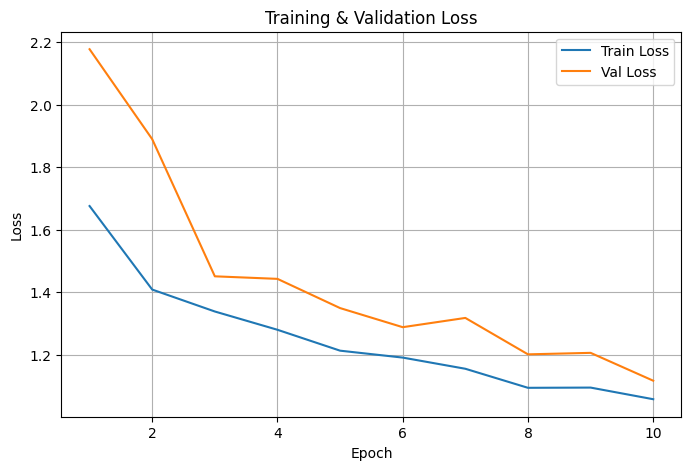

💾 Saved checkpoint: segformer_b5_adapter_epoch_10.pth
Epoch 011 | Train Loss: 1.0039 | Val Loss: 1.0983 | Val mIoU: 0.2505 | Val mCPA: 0.5422
Epoch 012 | Train Loss: 0.9809 | Val Loss: 1.0355 | Val mIoU: 0.2386 | Val mCPA: 0.4998
Epoch 013 | Train Loss: 0.9457 | Val Loss: 0.9629 | Val mIoU: 0.2472 | Val mCPA: 0.4906
Epoch 014 | Train Loss: 0.9081 | Val Loss: 0.9739 | Val mIoU: 0.2683 | Val mCPA: 0.5417
Epoch 015 | Train Loss: 0.8906 | Val Loss: 0.9170 | Val mIoU: 0.2783 | Val mCPA: 0.5521
Epoch 016 | Train Loss: 0.8553 | Val Loss: 0.8866 | Val mIoU: 0.2879 | Val mCPA: 0.5578
Epoch 017 | Train Loss: 0.8315 | Val Loss: 0.8816 | Val mIoU: 0.2910 | Val mCPA: 0.5700
Epoch 018 | Train Loss: 0.8316 | Val Loss: 0.8914 | Val mIoU: 0.3066 | Val mCPA: 0.5464
Epoch 019 | Train Loss: 0.8417 | Val Loss: 0.8369 | Val mIoU: 0.3264 | Val mCPA: 0.5624
Epoch 020 | Train Loss: 0.7839 | Val Loss: 0.8775 | Val mIoU: 0.3218 | Val mCPA: 0.5536


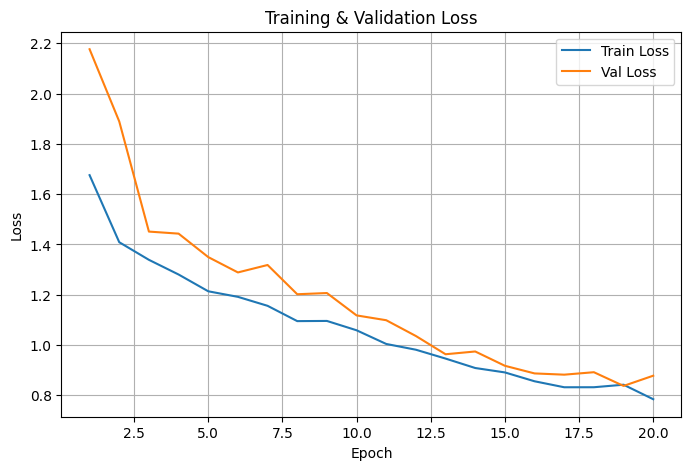

💾 Saved checkpoint: segformer_b5_adapter_epoch_20.pth
Epoch 021 | Train Loss: 0.7691 | Val Loss: 0.8175 | Val mIoU: 0.3407 | Val mCPA: 0.5706
Epoch 022 | Train Loss: 0.7376 | Val Loss: 0.8479 | Val mIoU: 0.3465 | Val mCPA: 0.5221
Epoch 023 | Train Loss: 0.7622 | Val Loss: 0.8420 | Val mIoU: 0.3212 | Val mCPA: 0.5859
Epoch 024 | Train Loss: 0.7524 | Val Loss: 0.8072 | Val mIoU: 0.3309 | Val mCPA: 0.5288
Epoch 025 | Train Loss: 0.7230 | Val Loss: 0.7613 | Val mIoU: 0.3644 | Val mCPA: 0.5927
Epoch 026 | Train Loss: 0.6971 | Val Loss: 0.7510 | Val mIoU: 0.3995 | Val mCPA: 0.5708
Epoch 027 | Train Loss: 0.6830 | Val Loss: 0.8123 | Val mIoU: 0.3345 | Val mCPA: 0.5774
Epoch 028 | Train Loss: 0.6866 | Val Loss: 0.7970 | Val mIoU: 0.3281 | Val mCPA: 0.5634
Epoch 029 | Train Loss: 0.6728 | Val Loss: 0.7816 | Val mIoU: 0.3230 | Val mCPA: 0.5795
Epoch 030 | Train Loss: 0.6562 | Val Loss: 0.7298 | Val mIoU: 0.3731 | Val mCPA: 0.5821


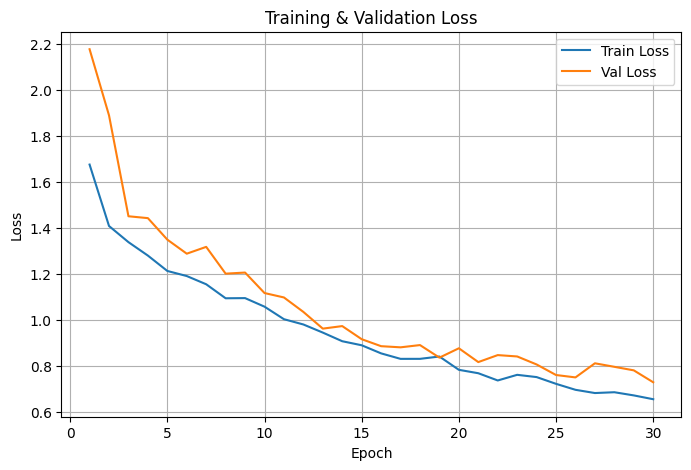

💾 Saved checkpoint: segformer_b5_adapter_epoch_30.pth
Epoch 031 | Train Loss: 0.6542 | Val Loss: 0.7518 | Val mIoU: 0.3620 | Val mCPA: 0.5728
Epoch 032 | Train Loss: 0.6298 | Val Loss: 0.7319 | Val mIoU: 0.3571 | Val mCPA: 0.6083
Epoch 033 | Train Loss: 0.6209 | Val Loss: 0.7215 | Val mIoU: 0.3560 | Val mCPA: 0.5710
Epoch 034 | Train Loss: 0.6164 | Val Loss: 0.7353 | Val mIoU: 0.3696 | Val mCPA: 0.5853
Epoch 035 | Train Loss: 0.6208 | Val Loss: 0.7608 | Val mIoU: 0.3788 | Val mCPA: 0.5946
Epoch 036 | Train Loss: 0.5957 | Val Loss: 0.7145 | Val mIoU: 0.3718 | Val mCPA: 0.5785
Epoch 037 | Train Loss: 0.5891 | Val Loss: 0.7150 | Val mIoU: 0.3711 | Val mCPA: 0.5728
Epoch 038 | Train Loss: 0.5644 | Val Loss: 0.7298 | Val mIoU: 0.3627 | Val mCPA: 0.5811
Epoch 039 | Train Loss: 0.5696 | Val Loss: 0.7264 | Val mIoU: 0.3605 | Val mCPA: 0.5945
Epoch 040 | Train Loss: 0.6113 | Val Loss: 0.7007 | Val mIoU: 0.3716 | Val mCPA: 0.5879


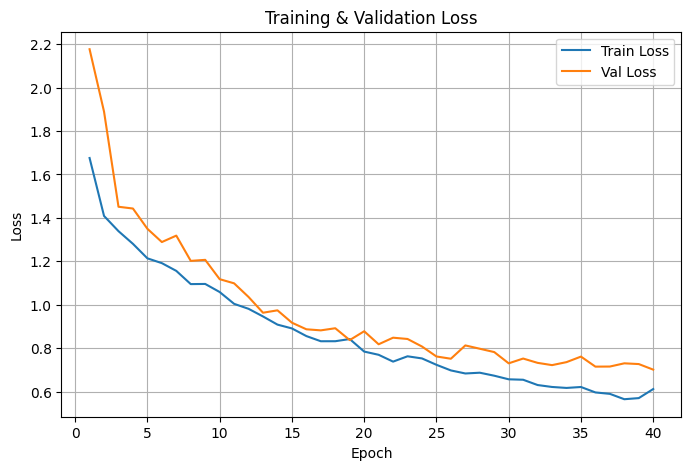

💾 Saved checkpoint: segformer_b5_adapter_epoch_40.pth
Epoch 041 | Train Loss: 0.5667 | Val Loss: 0.7110 | Val mIoU: 0.3765 | Val mCPA: 0.5986
Epoch 042 | Train Loss: 0.5756 | Val Loss: 0.6758 | Val mIoU: 0.4203 | Val mCPA: 0.6056
Epoch 043 | Train Loss: 0.5549 | Val Loss: 0.6738 | Val mIoU: 0.3912 | Val mCPA: 0.6023
Epoch 044 | Train Loss: 0.5620 | Val Loss: 0.6551 | Val mIoU: 0.4198 | Val mCPA: 0.6148
Epoch 045 | Train Loss: 0.5315 | Val Loss: 0.6765 | Val mIoU: 0.3796 | Val mCPA: 0.5853
Epoch 046 | Train Loss: 0.5388 | Val Loss: 0.6510 | Val mIoU: 0.4032 | Val mCPA: 0.6253
Epoch 047 | Train Loss: 0.5188 | Val Loss: 0.6563 | Val mIoU: 0.4057 | Val mCPA: 0.6372
Epoch 048 | Train Loss: 0.5166 | Val Loss: 0.6806 | Val mIoU: 0.3739 | Val mCPA: 0.6444
Epoch 049 | Train Loss: 0.5001 | Val Loss: 0.6553 | Val mIoU: 0.3900 | Val mCPA: 0.6230
Epoch 050 | Train Loss: 0.5145 | Val Loss: 0.6936 | Val mIoU: 0.3758 | Val mCPA: 0.6030


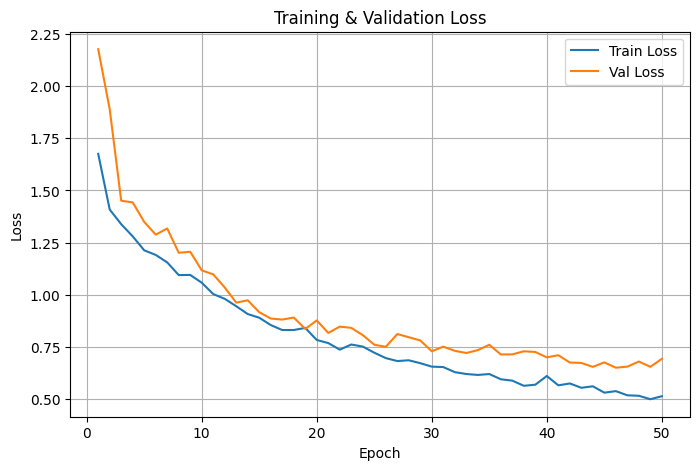

💾 Saved checkpoint: segformer_b5_adapter_epoch_50.pth
Epoch 051 | Train Loss: 0.5094 | Val Loss: 0.6595 | Val mIoU: 0.3855 | Val mCPA: 0.6318
Epoch 052 | Train Loss: 0.5300 | Val Loss: 0.6704 | Val mIoU: 0.3807 | Val mCPA: 0.6081
Epoch 053 | Train Loss: 0.4881 | Val Loss: 0.6462 | Val mIoU: 0.3980 | Val mCPA: 0.6241
Epoch 054 | Train Loss: 0.4893 | Val Loss: 0.6443 | Val mIoU: 0.4016 | Val mCPA: 0.6273
Epoch 055 | Train Loss: 0.4948 | Val Loss: 0.6418 | Val mIoU: 0.4118 | Val mCPA: 0.6207
Epoch 056 | Train Loss: 0.4894 | Val Loss: 0.6349 | Val mIoU: 0.4153 | Val mCPA: 0.6071
Epoch 057 | Train Loss: 0.5011 | Val Loss: 0.6575 | Val mIoU: 0.3862 | Val mCPA: 0.5803
Epoch 058 | Train Loss: 0.4709 | Val Loss: 0.7155 | Val mIoU: 0.3876 | Val mCPA: 0.6205
Epoch 059 | Train Loss: 0.4493 | Val Loss: 0.6154 | Val mIoU: 0.4418 | Val mCPA: 0.6291
Epoch 060 | Train Loss: 0.4788 | Val Loss: 0.6393 | Val mIoU: 0.4202 | Val mCPA: 0.6320


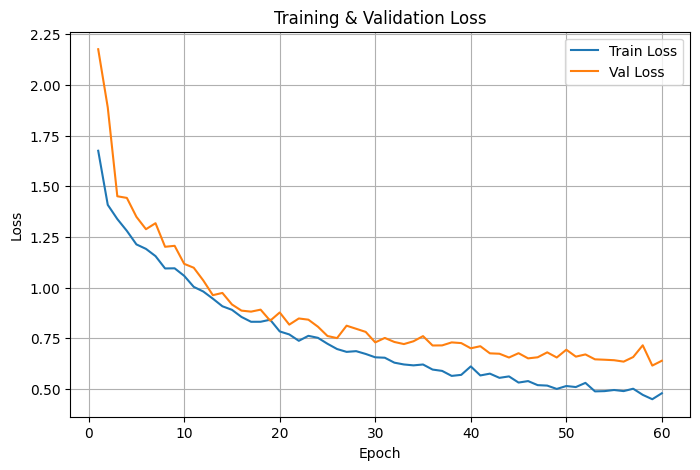

💾 Saved checkpoint: segformer_b5_adapter_epoch_60.pth
Epoch 061 | Train Loss: 0.4457 | Val Loss: 0.6321 | Val mIoU: 0.4048 | Val mCPA: 0.6459
Epoch 062 | Train Loss: 0.4611 | Val Loss: 0.6406 | Val mIoU: 0.4158 | Val mCPA: 0.6165
Epoch 063 | Train Loss: 0.4619 | Val Loss: 0.6302 | Val mIoU: 0.4071 | Val mCPA: 0.6006
Epoch 064 | Train Loss: 0.4422 | Val Loss: 0.6505 | Val mIoU: 0.3965 | Val mCPA: 0.6425
Epoch 065 | Train Loss: 0.4384 | Val Loss: 0.5991 | Val mIoU: 0.4234 | Val mCPA: 0.6322
Epoch 066 | Train Loss: 0.4418 | Val Loss: 0.6671 | Val mIoU: 0.3876 | Val mCPA: 0.6071
Epoch 067 | Train Loss: 0.4525 | Val Loss: 0.6406 | Val mIoU: 0.3850 | Val mCPA: 0.6133
Epoch 068 | Train Loss: 0.4479 | Val Loss: 0.6153 | Val mIoU: 0.4148 | Val mCPA: 0.6515
Epoch 069 | Train Loss: 0.4466 | Val Loss: 0.6117 | Val mIoU: 0.4300 | Val mCPA: 0.6305
Epoch 070 | Train Loss: 0.4471 | Val Loss: 0.6058 | Val mIoU: 0.4149 | Val mCPA: 0.6380


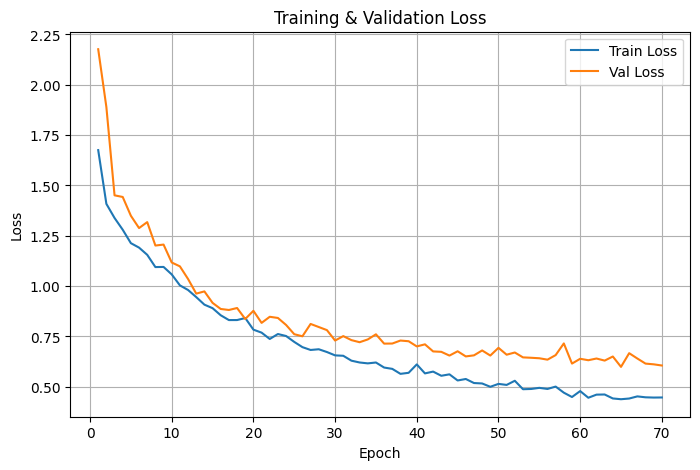

💾 Saved checkpoint: segformer_b5_adapter_epoch_70.pth
Epoch 071 | Train Loss: 0.4261 | Val Loss: 0.6077 | Val mIoU: 0.4211 | Val mCPA: 0.6323
Epoch 072 | Train Loss: 0.4077 | Val Loss: 0.6186 | Val mIoU: 0.4190 | Val mCPA: 0.6464
Epoch 073 | Train Loss: 0.4157 | Val Loss: 0.6052 | Val mIoU: 0.4245 | Val mCPA: 0.6189
Epoch 074 | Train Loss: 0.4275 | Val Loss: 0.6222 | Val mIoU: 0.4330 | Val mCPA: 0.6279
Epoch 075 | Train Loss: 0.4402 | Val Loss: 0.6112 | Val mIoU: 0.4335 | Val mCPA: 0.6324
Epoch 076 | Train Loss: 0.4163 | Val Loss: 0.6413 | Val mIoU: 0.4381 | Val mCPA: 0.6635
Epoch 077 | Train Loss: 0.4115 | Val Loss: 0.6216 | Val mIoU: 0.4277 | Val mCPA: 0.6256
Epoch 078 | Train Loss: 0.4000 | Val Loss: 0.6183 | Val mIoU: 0.4253 | Val mCPA: 0.6389
Epoch 079 | Train Loss: 0.4160 | Val Loss: 0.6279 | Val mIoU: 0.4187 | Val mCPA: 0.6338
Epoch 080 | Train Loss: 0.4057 | Val Loss: 0.6252 | Val mIoU: 0.4157 | Val mCPA: 0.6257


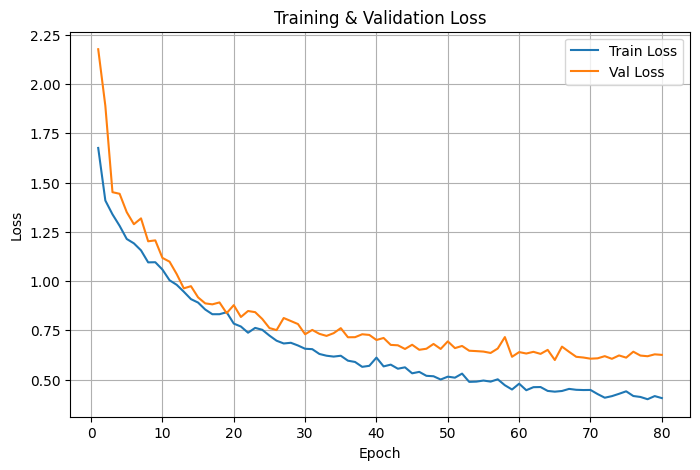

💾 Saved checkpoint: segformer_b5_adapter_epoch_80.pth
Epoch 081 | Train Loss: 0.4076 | Val Loss: 0.6145 | Val mIoU: 0.4173 | Val mCPA: 0.6271
Epoch 082 | Train Loss: 0.4049 | Val Loss: 0.6115 | Val mIoU: 0.4357 | Val mCPA: 0.6393
Epoch 083 | Train Loss: 0.4115 | Val Loss: 0.6181 | Val mIoU: 0.4363 | Val mCPA: 0.6277
Epoch 084 | Train Loss: 0.4019 | Val Loss: 0.5956 | Val mIoU: 0.4359 | Val mCPA: 0.6338
Epoch 085 | Train Loss: 0.4018 | Val Loss: 0.6324 | Val mIoU: 0.4255 | Val mCPA: 0.6357
Epoch 086 | Train Loss: 0.3887 | Val Loss: 0.6089 | Val mIoU: 0.4290 | Val mCPA: 0.6249
Epoch 087 | Train Loss: 0.3996 | Val Loss: 0.6414 | Val mIoU: 0.4356 | Val mCPA: 0.6253
Epoch 088 | Train Loss: 0.3921 | Val Loss: 0.6038 | Val mIoU: 0.4185 | Val mCPA: 0.6156
Epoch 089 | Train Loss: 0.3955 | Val Loss: 0.6099 | Val mIoU: 0.4379 | Val mCPA: 0.6494
Epoch 090 | Train Loss: 0.3955 | Val Loss: 0.6428 | Val mIoU: 0.4180 | Val mCPA: 0.6286


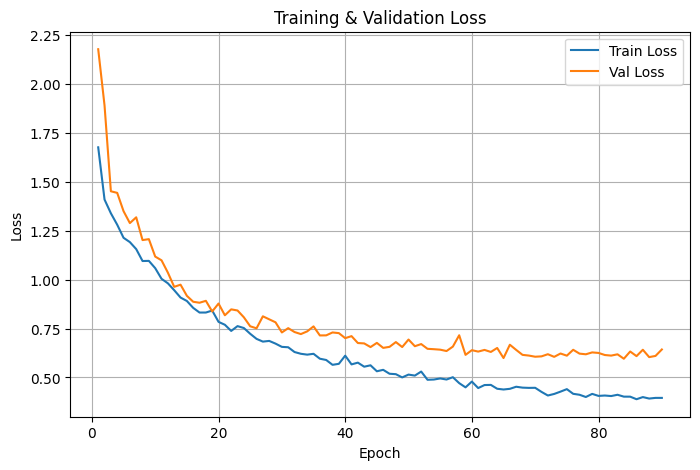

💾 Saved checkpoint: segformer_b5_adapter_epoch_90.pth


KeyboardInterrupt: 

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 9
NUM_EPOCHS = 500
LR = 1e-4   # higher for LoRA fine-tuning
WEIGHT_DECAY = 0.01




criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=WEIGHT_DECAY
)

train_losses, val_losses = [], []

def compute_metrics(pred, true, num_classes):
    correct = (pred == true).sum()
    total = np.prod(true.shape)
    CPA = []
    IoU = []
    for c in range(num_classes):
        tp = ((pred==c)&(true==c)).sum()
        fp = ((pred==c)&(true!=c)).sum()
        fn = ((pred!=c)&(true==c)).sum()
        cpa = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else np.nan
        IoU.append(iou)
        CPA.append(cpa)
    return np.nanmean(IoU), CPA

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.long().to(DEVICE)

        optimizer.zero_grad()
        outputs = model.base_model(imgs)

        # Handle dict outputs
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs

        # Upsample logits to match mask size
        logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)

        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ============================
    # Validation
    # ============================
    model.eval()
    epoch_val_loss = 0
    val_miou_list, val_cpa_list = [], []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.long().to(DEVICE)
            outputs = model.base_model(imgs)
            logits = outputs["logits"] if isinstance(outputs, dict) else outputs
            logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)

            loss = criterion(logits, masks)
            epoch_val_loss += loss.item()

            preds = logits.argmax(dim=1).cpu().numpy()
            masks_np = masks.cpu().numpy()
            for p, t in zip(preds, masks_np):
                miou, cpa = compute_metrics(p, t, NUM_CLASSES)
                val_miou_list.append(miou)
                val_cpa_list.append(cpa)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    mean_val_miou = np.nanmean(val_miou_list)
    mean_val_cpa = np.nanmean(val_cpa_list)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val mIoU: {mean_val_miou:.4f} | "
          f"Val mCPA: {mean_val_cpa:.4f}")

    # ============================
    # Periodic Save & Plot
    # ============================
    if (epoch + 1) % 10 == 0:
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training & Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses
        }, f"segformer_b5_adapter_epoch_{epoch+1}.pth")

        print(f"💾 Saved checkpoint: segformer_b5_adapter_epoch_{epoch+1}.pth")

print("✅ Training complete!")

In [7]:
num_classes = 9
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
model = SegformerForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True )

# Adapt first conv to 2 channels
old_conv = model.segformer.encoder.patch_embeddings[0].proj
new_conv = nn.Conv2d(
    2, old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None
)
with torch.no_grad():
    new_conv.weight[:, :2] = old_conv.weight[:, :2]
model.segformer.encoder.patch_embeddings[0].proj = new_conv

# Reinitialize decoder
def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.decode_head.apply(init_weights_kaiming)

model.to(DEVICE)

# ===============================
# 4️⃣ LoRA Adapter Setup
# ===============================
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=32,                # increase rank for more adaptation
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query","value"]
)
model = get_peft_model(model, lora_config)

# Freeze all except decoder + LoRA + last 4 encoder blocks
for name, param in model.named_parameters():
    param.requires_grad = False

# Decoder
for name, param in model.decode_head.named_parameters():
    param.requires_grad = True

# LoRA parameters
for name, param in model.named_parameters():
    if "lora_" in name:
        param.requires_grad = True


# Unfreeze last 2 encoder stages (example)
for stage in model.segformer.encoder.block[-1:]:
    for layer in stage:
        for param in layer.parameters():
            param.requires_grad = True


# Check trainable params
trainable = sum(p.numel() for p in model.base_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.base_model.parameters())
print(f"Trainable params: {trainable/total*100:.2f}% of total")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([9, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 16.91% of total


Trainable params: 16.91% of total
Epoch 001 | Train Loss: 2.3029 | Val Loss: 2.1901 | Val mIoU: 0.0405 | Val mCPA: 0.1959
Epoch 002 | Train Loss: 2.1080 | Val Loss: 2.1606 | Val mIoU: 0.0409 | Val mCPA: 0.2020
Epoch 003 | Train Loss: 1.9650 | Val Loss: 2.0306 | Val mIoU: 0.0644 | Val mCPA: 0.2694
Epoch 004 | Train Loss: 1.8369 | Val Loss: 1.8769 | Val mIoU: 0.0771 | Val mCPA: 0.3409
Epoch 005 | Train Loss: 1.7830 | Val Loss: 1.7824 | Val mIoU: 0.0804 | Val mCPA: 0.3598
Epoch 006 | Train Loss: 1.6411 | Val Loss: 1.6896 | Val mIoU: 0.1032 | Val mCPA: 0.3440
Epoch 007 | Train Loss: 1.5830 | Val Loss: 1.6451 | Val mIoU: 0.1202 | Val mCPA: 0.3396
Epoch 008 | Train Loss: 1.5752 | Val Loss: 1.6232 | Val mIoU: 0.1184 | Val mCPA: 0.3318
Epoch 009 | Train Loss: 1.5315 | Val Loss: 1.5940 | Val mIoU: 0.1186 | Val mCPA: 0.3279
Epoch 010 | Train Loss: 1.5191 | Val Loss: 1.5768 | Val mIoU: 0.1173 | Val mCPA: 0.3227


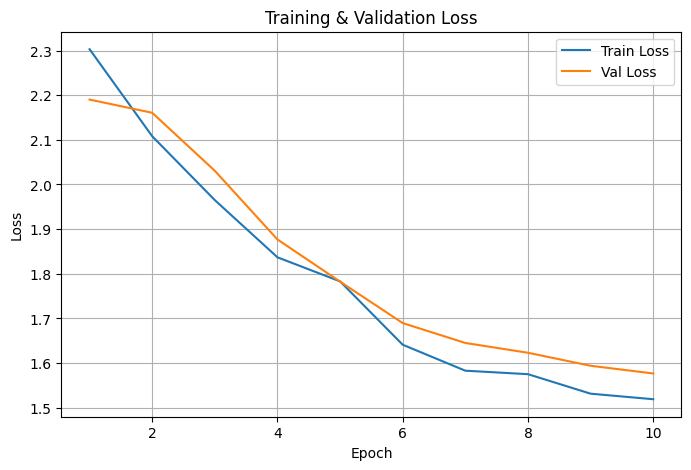

💾 Saved checkpoint: segformer_b5_adapter_epoch_10.pth
Epoch 011 | Train Loss: 1.4821 | Val Loss: 1.5623 | Val mIoU: 0.1211 | Val mCPA: 0.3311
Epoch 012 | Train Loss: 1.4509 | Val Loss: 1.5474 | Val mIoU: 0.1199 | Val mCPA: 0.3241
Epoch 013 | Train Loss: 1.4421 | Val Loss: 1.5276 | Val mIoU: 0.1324 | Val mCPA: 0.3188
Epoch 014 | Train Loss: 1.4065 | Val Loss: 1.5173 | Val mIoU: 0.1285 | Val mCPA: 0.3242
Epoch 015 | Train Loss: 1.4432 | Val Loss: 1.5142 | Val mIoU: 0.1223 | Val mCPA: 0.3250
Epoch 016 | Train Loss: 1.4075 | Val Loss: 1.5018 | Val mIoU: 0.1273 | Val mCPA: 0.3283
Epoch 017 | Train Loss: 1.4101 | Val Loss: 1.4912 | Val mIoU: 0.1305 | Val mCPA: 0.3269
Epoch 018 | Train Loss: 1.3991 | Val Loss: 1.4795 | Val mIoU: 0.1287 | Val mCPA: 0.3346
Epoch 019 | Train Loss: 1.3881 | Val Loss: 1.4719 | Val mIoU: 0.1383 | Val mCPA: 0.3441
Epoch 020 | Train Loss: 1.3553 | Val Loss: 1.4569 | Val mIoU: 0.1300 | Val mCPA: 0.3267


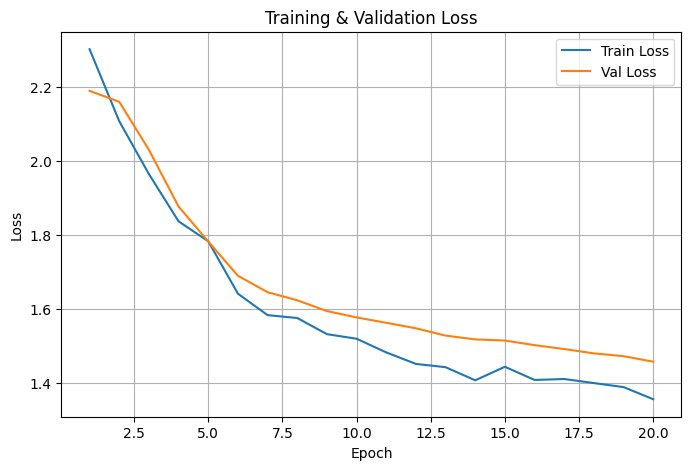

💾 Saved checkpoint: segformer_b5_adapter_epoch_20.pth
Epoch 021 | Train Loss: 1.3510 | Val Loss: 1.4506 | Val mIoU: 0.1349 | Val mCPA: 0.3382
Epoch 022 | Train Loss: 1.3876 | Val Loss: 1.4448 | Val mIoU: 0.1346 | Val mCPA: 0.3443
Epoch 023 | Train Loss: 1.3413 | Val Loss: 1.4291 | Val mIoU: 0.1364 | Val mCPA: 0.3375
Epoch 024 | Train Loss: 1.3632 | Val Loss: 1.4255 | Val mIoU: 0.1450 | Val mCPA: 0.3538
Epoch 025 | Train Loss: 1.3390 | Val Loss: 1.4089 | Val mIoU: 0.1522 | Val mCPA: 0.3518
Epoch 026 | Train Loss: 1.3271 | Val Loss: 1.4059 | Val mIoU: 0.1685 | Val mCPA: 0.3595
Epoch 027 | Train Loss: 1.3280 | Val Loss: 1.4022 | Val mIoU: 0.1712 | Val mCPA: 0.3769
Epoch 028 | Train Loss: 1.3034 | Val Loss: 1.4076 | Val mIoU: 0.1832 | Val mCPA: 0.3789
Epoch 029 | Train Loss: 1.3200 | Val Loss: 1.3880 | Val mIoU: 0.1809 | Val mCPA: 0.3823
Epoch 030 | Train Loss: 1.2884 | Val Loss: 1.3888 | Val mIoU: 0.1960 | Val mCPA: 0.3810


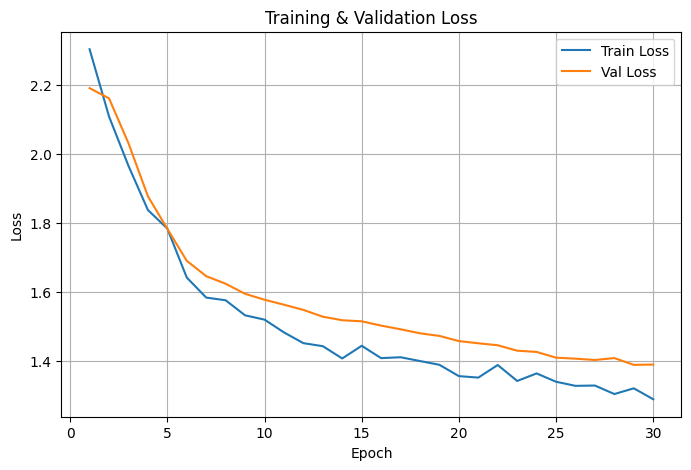

💾 Saved checkpoint: segformer_b5_adapter_epoch_30.pth
Epoch 031 | Train Loss: 1.2970 | Val Loss: 1.3597 | Val mIoU: 0.1800 | Val mCPA: 0.3820
Epoch 032 | Train Loss: 1.2834 | Val Loss: 1.3639 | Val mIoU: 0.1972 | Val mCPA: 0.3918
Epoch 033 | Train Loss: 1.2563 | Val Loss: 1.3529 | Val mIoU: 0.2001 | Val mCPA: 0.4008
Epoch 034 | Train Loss: 1.2468 | Val Loss: 1.3702 | Val mIoU: 0.1943 | Val mCPA: 0.3848
Epoch 035 | Train Loss: 1.2418 | Val Loss: 1.3452 | Val mIoU: 0.2072 | Val mCPA: 0.4021
Epoch 036 | Train Loss: 1.2455 | Val Loss: 1.3483 | Val mIoU: 0.2001 | Val mCPA: 0.3993
Epoch 037 | Train Loss: 1.2385 | Val Loss: 1.3273 | Val mIoU: 0.2002 | Val mCPA: 0.4006
Epoch 038 | Train Loss: 1.2427 | Val Loss: 1.3260 | Val mIoU: 0.1921 | Val mCPA: 0.4072
Epoch 039 | Train Loss: 1.2375 | Val Loss: 1.3004 | Val mIoU: 0.2138 | Val mCPA: 0.4107
Epoch 040 | Train Loss: 1.2167 | Val Loss: 1.2874 | Val mIoU: 0.2190 | Val mCPA: 0.4202


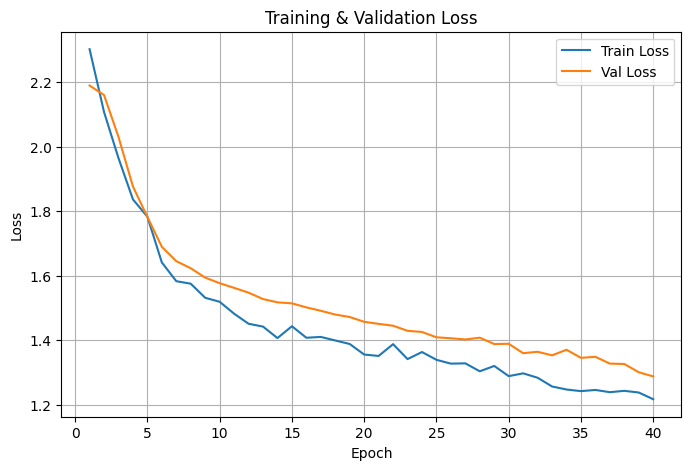

💾 Saved checkpoint: segformer_b5_adapter_epoch_40.pth
Epoch 041 | Train Loss: 1.2253 | Val Loss: 1.2745 | Val mIoU: 0.2246 | Val mCPA: 0.4114
Epoch 042 | Train Loss: 1.2078 | Val Loss: 1.2631 | Val mIoU: 0.2366 | Val mCPA: 0.4280
Epoch 043 | Train Loss: 1.1969 | Val Loss: 1.2752 | Val mIoU: 0.2155 | Val mCPA: 0.4230
Epoch 044 | Train Loss: 1.1775 | Val Loss: 1.3203 | Val mIoU: 0.2159 | Val mCPA: 0.4078
Epoch 045 | Train Loss: 1.1864 | Val Loss: 1.2660 | Val mIoU: 0.2113 | Val mCPA: 0.4214
Epoch 046 | Train Loss: 1.1681 | Val Loss: 1.2608 | Val mIoU: 0.2179 | Val mCPA: 0.4282
Epoch 047 | Train Loss: 1.1788 | Val Loss: 1.2621 | Val mIoU: 0.2167 | Val mCPA: 0.4151
Epoch 048 | Train Loss: 1.1842 | Val Loss: 1.2183 | Val mIoU: 0.2226 | Val mCPA: 0.4392
Epoch 049 | Train Loss: 1.1292 | Val Loss: 1.2505 | Val mIoU: 0.2137 | Val mCPA: 0.4201
Epoch 050 | Train Loss: 1.1496 | Val Loss: 1.2013 | Val mIoU: 0.2203 | Val mCPA: 0.4362


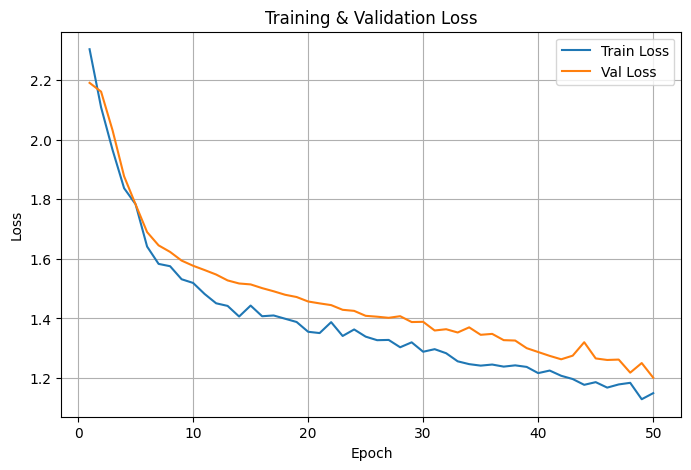

💾 Saved checkpoint: segformer_b5_adapter_epoch_50.pth
Epoch 051 | Train Loss: 1.1643 | Val Loss: 1.2366 | Val mIoU: 0.2106 | Val mCPA: 0.4259
Epoch 052 | Train Loss: 1.1346 | Val Loss: 1.1948 | Val mIoU: 0.2196 | Val mCPA: 0.4318
Epoch 053 | Train Loss: 1.1443 | Val Loss: 1.2196 | Val mIoU: 0.2241 | Val mCPA: 0.4262
Epoch 054 | Train Loss: 1.1732 | Val Loss: 1.2019 | Val mIoU: 0.2092 | Val mCPA: 0.4474
Epoch 055 | Train Loss: 1.1506 | Val Loss: 1.1949 | Val mIoU: 0.2176 | Val mCPA: 0.4397
Epoch 056 | Train Loss: 1.1451 | Val Loss: 1.2299 | Val mIoU: 0.2065 | Val mCPA: 0.4339
Epoch 057 | Train Loss: 1.0889 | Val Loss: 1.1640 | Val mIoU: 0.2508 | Val mCPA: 0.4512
Epoch 058 | Train Loss: 1.0949 | Val Loss: 1.1797 | Val mIoU: 0.2457 | Val mCPA: 0.4522
Epoch 059 | Train Loss: 1.1035 | Val Loss: 1.1490 | Val mIoU: 0.2341 | Val mCPA: 0.4636
Epoch 060 | Train Loss: 1.0718 | Val Loss: 1.1387 | Val mIoU: 0.2314 | Val mCPA: 0.4624


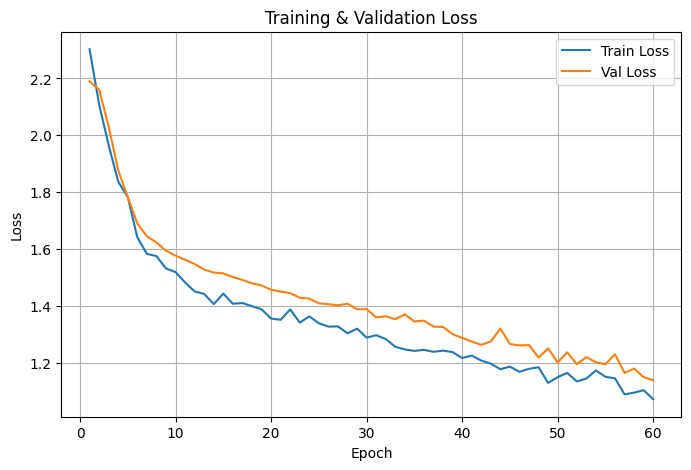

💾 Saved checkpoint: segformer_b5_adapter_epoch_60.pth
Epoch 061 | Train Loss: 1.1282 | Val Loss: 1.1588 | Val mIoU: 0.2329 | Val mCPA: 0.4640
Epoch 062 | Train Loss: 1.0690 | Val Loss: 1.1419 | Val mIoU: 0.2292 | Val mCPA: 0.4676
Epoch 063 | Train Loss: 1.0542 | Val Loss: 1.1362 | Val mIoU: 0.2236 | Val mCPA: 0.4812
Epoch 064 | Train Loss: 1.0795 | Val Loss: 1.1456 | Val mIoU: 0.2267 | Val mCPA: 0.4647
Epoch 065 | Train Loss: 1.0695 | Val Loss: 1.1308 | Val mIoU: 0.2308 | Val mCPA: 0.4611
Epoch 066 | Train Loss: 1.1110 | Val Loss: 1.1140 | Val mIoU: 0.2463 | Val mCPA: 0.4684
Epoch 067 | Train Loss: 1.0512 | Val Loss: 1.1215 | Val mIoU: 0.2400 | Val mCPA: 0.4605
Epoch 068 | Train Loss: 1.0532 | Val Loss: 1.1187 | Val mIoU: 0.2346 | Val mCPA: 0.4729
Epoch 069 | Train Loss: 1.0430 | Val Loss: 1.1319 | Val mIoU: 0.2395 | Val mCPA: 0.4766
Epoch 070 | Train Loss: 1.0442 | Val Loss: 1.2647 | Val mIoU: 0.2119 | Val mCPA: 0.4518


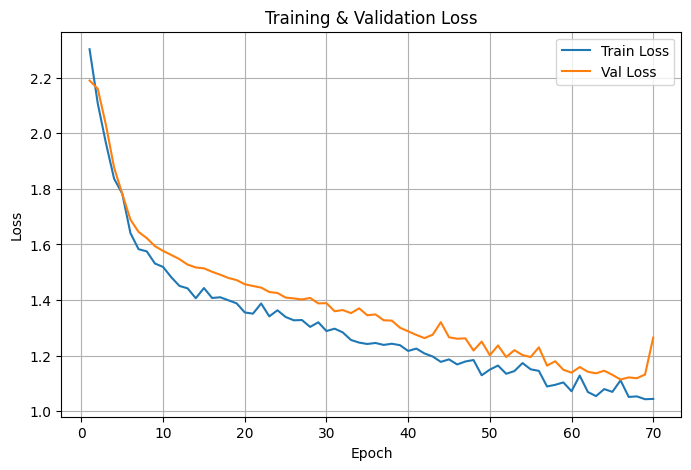

💾 Saved checkpoint: segformer_b5_adapter_epoch_70.pth
Epoch 071 | Train Loss: 1.0235 | Val Loss: 1.1168 | Val mIoU: 0.2449 | Val mCPA: 0.4895
Epoch 072 | Train Loss: 1.0609 | Val Loss: 1.1210 | Val mIoU: 0.2434 | Val mCPA: 0.4783
Epoch 073 | Train Loss: 1.0408 | Val Loss: 1.1003 | Val mIoU: 0.2536 | Val mCPA: 0.5002
Epoch 074 | Train Loss: 1.0459 | Val Loss: 1.1113 | Val mIoU: 0.2470 | Val mCPA: 0.4842
Epoch 075 | Train Loss: 1.0104 | Val Loss: 1.0921 | Val mIoU: 0.2522 | Val mCPA: 0.4950
Epoch 076 | Train Loss: 1.0467 | Val Loss: 1.0912 | Val mIoU: 0.2417 | Val mCPA: 0.4990
Epoch 077 | Train Loss: 1.0165 | Val Loss: 1.1153 | Val mIoU: 0.2361 | Val mCPA: 0.5008
Epoch 078 | Train Loss: 1.0159 | Val Loss: 1.0712 | Val mIoU: 0.2544 | Val mCPA: 0.5002
Epoch 079 | Train Loss: 1.0462 | Val Loss: 1.0537 | Val mIoU: 0.2599 | Val mCPA: 0.4931
Epoch 080 | Train Loss: 0.9794 | Val Loss: 1.0617 | Val mIoU: 0.2557 | Val mCPA: 0.4979


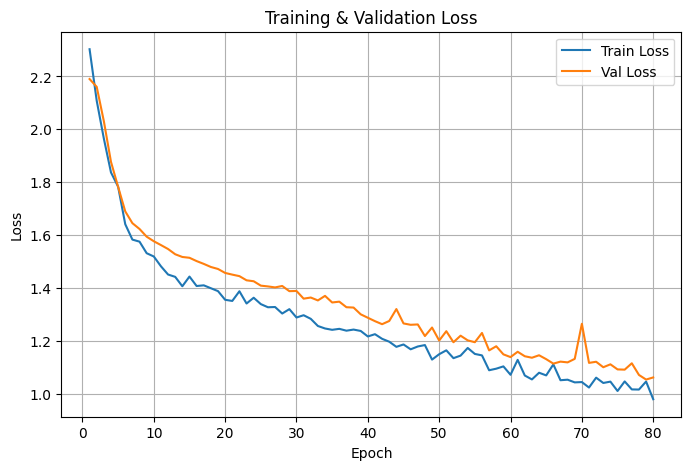

💾 Saved checkpoint: segformer_b5_adapter_epoch_80.pth
Epoch 081 | Train Loss: 1.0042 | Val Loss: 1.0590 | Val mIoU: 0.2547 | Val mCPA: 0.4934
Epoch 082 | Train Loss: 1.0119 | Val Loss: 1.0484 | Val mIoU: 0.2542 | Val mCPA: 0.5182
Epoch 083 | Train Loss: 0.9950 | Val Loss: 1.0442 | Val mIoU: 0.2548 | Val mCPA: 0.5156
Epoch 084 | Train Loss: 1.0070 | Val Loss: 1.0483 | Val mIoU: 0.2627 | Val mCPA: 0.5216
Epoch 085 | Train Loss: 0.9695 | Val Loss: 1.0486 | Val mIoU: 0.2587 | Val mCPA: 0.5150
Epoch 086 | Train Loss: 0.9837 | Val Loss: 1.0410 | Val mIoU: 0.2720 | Val mCPA: 0.5174
Epoch 087 | Train Loss: 0.9777 | Val Loss: 1.0706 | Val mIoU: 0.2616 | Val mCPA: 0.5223
Epoch 088 | Train Loss: 0.9875 | Val Loss: 1.0442 | Val mIoU: 0.2775 | Val mCPA: 0.5193
Epoch 089 | Train Loss: 0.9993 | Val Loss: 1.0569 | Val mIoU: 0.2638 | Val mCPA: 0.5342
Epoch 090 | Train Loss: 0.9652 | Val Loss: 1.0524 | Val mIoU: 0.2667 | Val mCPA: 0.5014


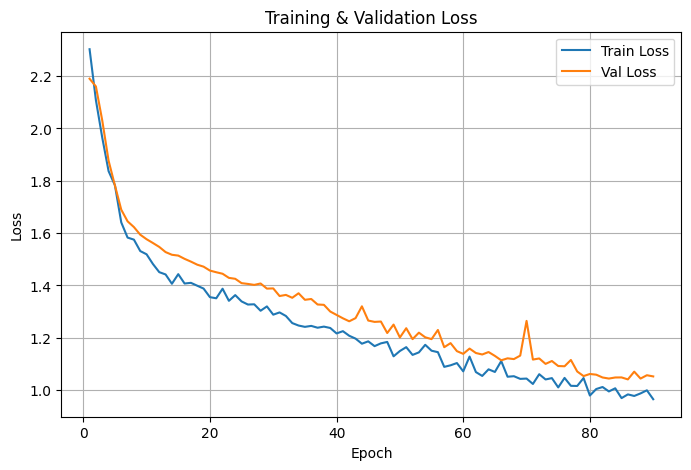

💾 Saved checkpoint: segformer_b5_adapter_epoch_90.pth
Epoch 091 | Train Loss: 0.9572 | Val Loss: 1.0485 | Val mIoU: 0.2640 | Val mCPA: 0.5060
Epoch 092 | Train Loss: 0.9846 | Val Loss: 1.0402 | Val mIoU: 0.2520 | Val mCPA: 0.5262
Epoch 093 | Train Loss: 0.9918 | Val Loss: 1.0424 | Val mIoU: 0.2593 | Val mCPA: 0.5110
Epoch 094 | Train Loss: 0.9917 | Val Loss: 1.0397 | Val mIoU: 0.2597 | Val mCPA: 0.5248
Epoch 095 | Train Loss: 0.9656 | Val Loss: 1.0192 | Val mIoU: 0.2769 | Val mCPA: 0.5274
Epoch 096 | Train Loss: 0.9544 | Val Loss: 1.0290 | Val mIoU: 0.2734 | Val mCPA: 0.5218
Epoch 097 | Train Loss: 0.9422 | Val Loss: 1.0071 | Val mIoU: 0.2824 | Val mCPA: 0.5270
Epoch 098 | Train Loss: 0.9481 | Val Loss: 1.0331 | Val mIoU: 0.2670 | Val mCPA: 0.5265
Epoch 099 | Train Loss: 0.9891 | Val Loss: 1.0209 | Val mIoU: 0.2637 | Val mCPA: 0.5212
Epoch 100 | Train Loss: 0.9572 | Val Loss: 1.0003 | Val mIoU: 0.2846 | Val mCPA: 0.5311


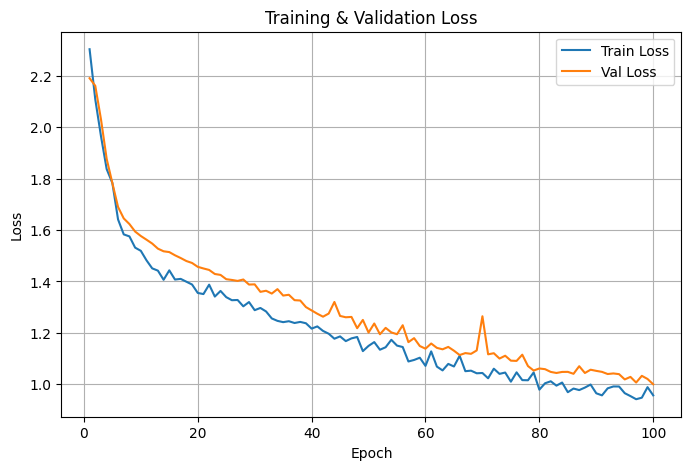

💾 Saved checkpoint: segformer_b5_adapter_epoch_100.pth
Epoch 101 | Train Loss: 0.9240 | Val Loss: 1.0346 | Val mIoU: 0.2716 | Val mCPA: 0.5222
Epoch 102 | Train Loss: 0.9115 | Val Loss: 1.0236 | Val mIoU: 0.2708 | Val mCPA: 0.5113
Epoch 103 | Train Loss: 0.9493 | Val Loss: 1.0103 | Val mIoU: 0.2880 | Val mCPA: 0.5267
Epoch 104 | Train Loss: 0.9387 | Val Loss: 1.0748 | Val mIoU: 0.2786 | Val mCPA: 0.5000
Epoch 105 | Train Loss: 0.9511 | Val Loss: 0.9862 | Val mIoU: 0.2821 | Val mCPA: 0.5341
Epoch 106 | Train Loss: 0.9153 | Val Loss: 0.9937 | Val mIoU: 0.2807 | Val mCPA: 0.5315
Epoch 107 | Train Loss: 0.9101 | Val Loss: 0.9962 | Val mIoU: 0.2874 | Val mCPA: 0.5390
Epoch 108 | Train Loss: 0.9184 | Val Loss: 0.9802 | Val mIoU: 0.2855 | Val mCPA: 0.5247
Epoch 109 | Train Loss: 0.9362 | Val Loss: 1.0000 | Val mIoU: 0.2829 | Val mCPA: 0.5238
Epoch 110 | Train Loss: 0.9220 | Val Loss: 0.9898 | Val mIoU: 0.2921 | Val mCPA: 0.5314


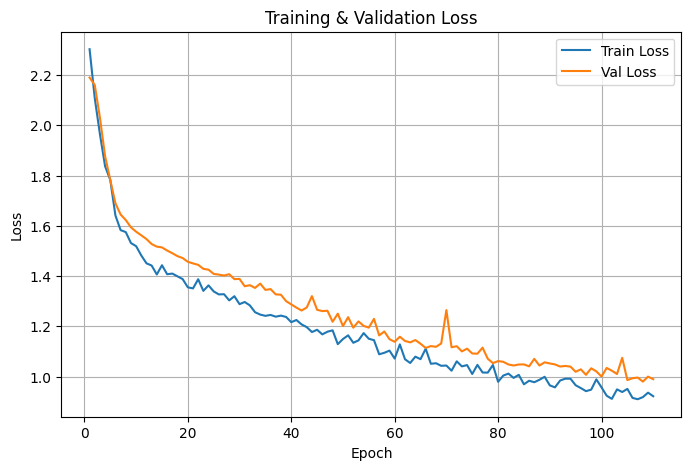

💾 Saved checkpoint: segformer_b5_adapter_epoch_110.pth
Epoch 111 | Train Loss: 0.9103 | Val Loss: 0.9806 | Val mIoU: 0.2922 | Val mCPA: 0.5358
Epoch 112 | Train Loss: 0.9373 | Val Loss: 0.9961 | Val mIoU: 0.2903 | Val mCPA: 0.5440
Epoch 113 | Train Loss: 0.9494 | Val Loss: 0.9894 | Val mIoU: 0.2900 | Val mCPA: 0.5219
Epoch 114 | Train Loss: 0.9289 | Val Loss: 0.9754 | Val mIoU: 0.2901 | Val mCPA: 0.5256
Epoch 115 | Train Loss: 0.9340 | Val Loss: 0.9634 | Val mIoU: 0.2998 | Val mCPA: 0.5488
Epoch 116 | Train Loss: 0.8810 | Val Loss: 0.9575 | Val mIoU: 0.3043 | Val mCPA: 0.5417
Epoch 117 | Train Loss: 0.9255 | Val Loss: 0.9468 | Val mIoU: 0.3078 | Val mCPA: 0.5473
Epoch 118 | Train Loss: 0.9111 | Val Loss: 0.9499 | Val mIoU: 0.3045 | Val mCPA: 0.5508
Epoch 119 | Train Loss: 0.9095 | Val Loss: 0.9539 | Val mIoU: 0.3091 | Val mCPA: 0.5496
Epoch 120 | Train Loss: 0.9244 | Val Loss: 0.9444 | Val mIoU: 0.3041 | Val mCPA: 0.5519


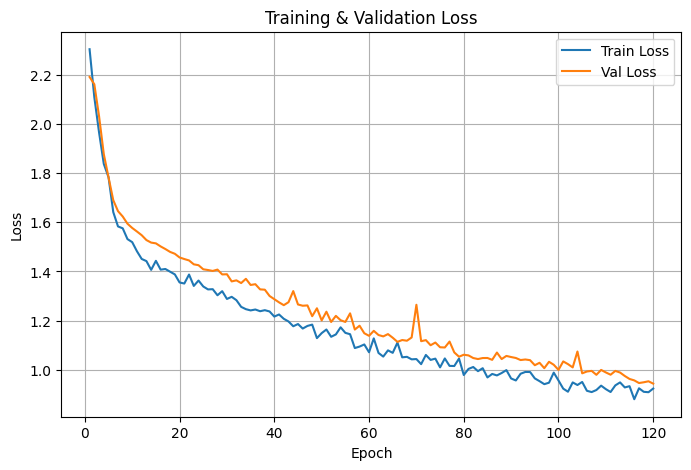

💾 Saved checkpoint: segformer_b5_adapter_epoch_120.pth
Epoch 121 | Train Loss: 0.8906 | Val Loss: 0.9666 | Val mIoU: 0.2918 | Val mCPA: 0.5400
Epoch 122 | Train Loss: 0.9191 | Val Loss: 0.9651 | Val mIoU: 0.3015 | Val mCPA: 0.5426
Epoch 123 | Train Loss: 0.8738 | Val Loss: 0.9411 | Val mIoU: 0.3072 | Val mCPA: 0.5450
Epoch 124 | Train Loss: 0.8916 | Val Loss: 0.9388 | Val mIoU: 0.2985 | Val mCPA: 0.5576
Epoch 125 | Train Loss: 0.8460 | Val Loss: 0.9471 | Val mIoU: 0.3164 | Val mCPA: 0.5573
Epoch 126 | Train Loss: 0.8653 | Val Loss: 0.9468 | Val mIoU: 0.2947 | Val mCPA: 0.5321
Epoch 127 | Train Loss: 0.8792 | Val Loss: 0.9430 | Val mIoU: 0.2888 | Val mCPA: 0.5616
Epoch 128 | Train Loss: 0.9068 | Val Loss: 0.9549 | Val mIoU: 0.3024 | Val mCPA: 0.5434
Epoch 129 | Train Loss: 0.9015 | Val Loss: 0.9525 | Val mIoU: 0.3178 | Val mCPA: 0.5560
Epoch 130 | Train Loss: 0.8337 | Val Loss: 0.9397 | Val mIoU: 0.3133 | Val mCPA: 0.5523


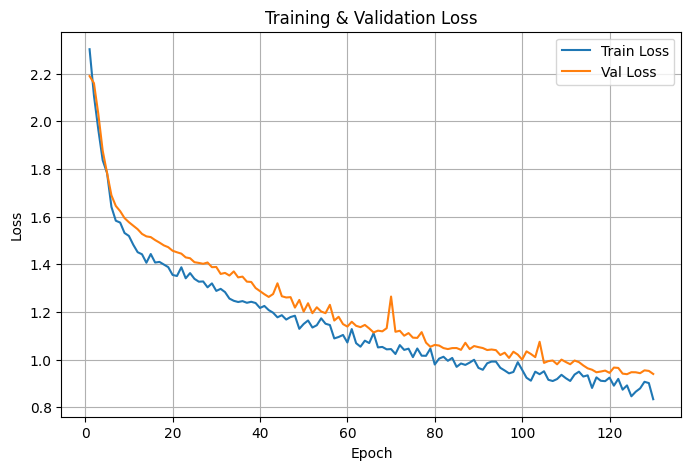

💾 Saved checkpoint: segformer_b5_adapter_epoch_130.pth
Epoch 131 | Train Loss: 0.8666 | Val Loss: 0.9428 | Val mIoU: 0.3117 | Val mCPA: 0.5533
Epoch 132 | Train Loss: 0.8745 | Val Loss: 0.9383 | Val mIoU: 0.3076 | Val mCPA: 0.5492
Epoch 133 | Train Loss: 0.8447 | Val Loss: 0.9282 | Val mIoU: 0.3100 | Val mCPA: 0.5522
Epoch 134 | Train Loss: 0.8137 | Val Loss: 0.9360 | Val mIoU: 0.3143 | Val mCPA: 0.5525
Epoch 135 | Train Loss: 0.8588 | Val Loss: 0.9250 | Val mIoU: 0.3110 | Val mCPA: 0.5541
Epoch 136 | Train Loss: 0.8479 | Val Loss: 0.9192 | Val mIoU: 0.3045 | Val mCPA: 0.5472
Epoch 137 | Train Loss: 0.8561 | Val Loss: 0.9185 | Val mIoU: 0.3248 | Val mCPA: 0.5591
Epoch 138 | Train Loss: 0.8465 | Val Loss: 0.9370 | Val mIoU: 0.3198 | Val mCPA: 0.5586
Epoch 139 | Train Loss: 0.8674 | Val Loss: 0.9528 | Val mIoU: 0.3062 | Val mCPA: 0.5615
Epoch 140 | Train Loss: 0.8416 | Val Loss: 0.9209 | Val mIoU: 0.3255 | Val mCPA: 0.5645


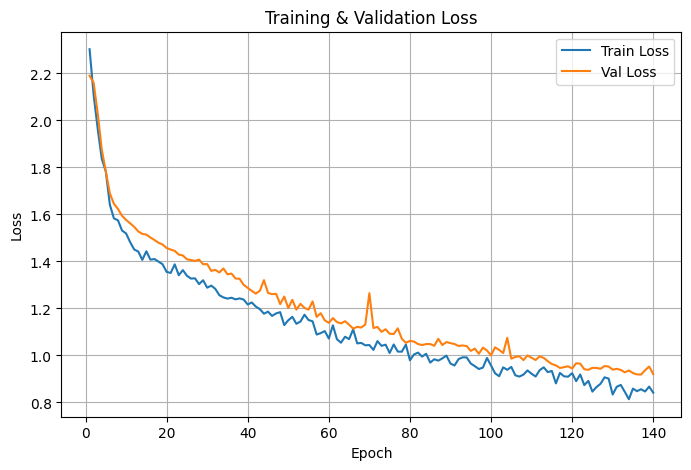

💾 Saved checkpoint: segformer_b5_adapter_epoch_140.pth
Epoch 141 | Train Loss: 0.8521 | Val Loss: 0.9021 | Val mIoU: 0.3226 | Val mCPA: 0.5532
Epoch 142 | Train Loss: 0.8269 | Val Loss: 0.9135 | Val mIoU: 0.3224 | Val mCPA: 0.5611
Epoch 143 | Train Loss: 0.8312 | Val Loss: 0.9156 | Val mIoU: 0.3176 | Val mCPA: 0.5637
Epoch 144 | Train Loss: 0.8449 | Val Loss: 0.9178 | Val mIoU: 0.3170 | Val mCPA: 0.5608
Epoch 145 | Train Loss: 0.8265 | Val Loss: 0.8999 | Val mIoU: 0.3146 | Val mCPA: 0.5578
Epoch 146 | Train Loss: 0.8189 | Val Loss: 0.8894 | Val mIoU: 0.3181 | Val mCPA: 0.5646
Epoch 147 | Train Loss: 0.8286 | Val Loss: 0.9182 | Val mIoU: 0.3174 | Val mCPA: 0.5684
Epoch 148 | Train Loss: 0.8056 | Val Loss: 0.8813 | Val mIoU: 0.3113 | Val mCPA: 0.5573
Epoch 149 | Train Loss: 0.8166 | Val Loss: 0.8874 | Val mIoU: 0.3106 | Val mCPA: 0.5625
Epoch 150 | Train Loss: 0.8392 | Val Loss: 0.8887 | Val mIoU: 0.3243 | Val mCPA: 0.5698


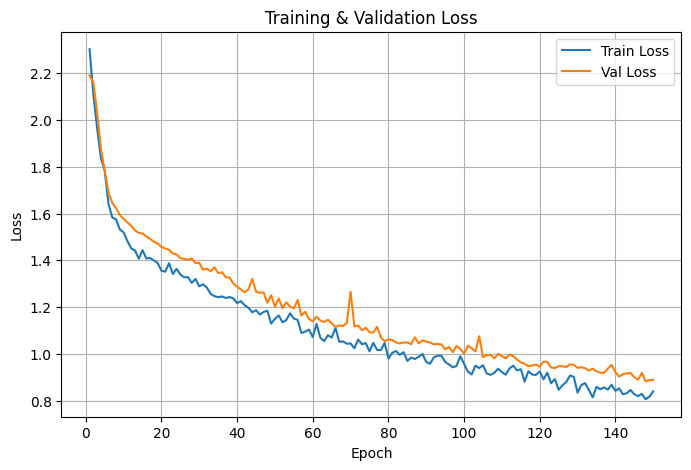

💾 Saved checkpoint: segformer_b5_adapter_epoch_150.pth
Epoch 151 | Train Loss: 0.8669 | Val Loss: 0.8954 | Val mIoU: 0.3123 | Val mCPA: 0.5578
Epoch 152 | Train Loss: 0.8329 | Val Loss: 0.8667 | Val mIoU: 0.3214 | Val mCPA: 0.5599
Epoch 153 | Train Loss: 0.8186 | Val Loss: 0.8763 | Val mIoU: 0.3214 | Val mCPA: 0.5705
Epoch 154 | Train Loss: 0.8270 | Val Loss: 0.8718 | Val mIoU: 0.3117 | Val mCPA: 0.5649
Epoch 155 | Train Loss: 0.7843 | Val Loss: 0.8894 | Val mIoU: 0.3078 | Val mCPA: 0.5586
Epoch 156 | Train Loss: 0.8083 | Val Loss: 0.8789 | Val mIoU: 0.3108 | Val mCPA: 0.5609
Epoch 157 | Train Loss: 0.7997 | Val Loss: 0.8660 | Val mIoU: 0.3173 | Val mCPA: 0.5551
Epoch 158 | Train Loss: 0.7847 | Val Loss: 0.8797 | Val mIoU: 0.3170 | Val mCPA: 0.5607
Epoch 159 | Train Loss: 0.7971 | Val Loss: 0.8789 | Val mIoU: 0.3006 | Val mCPA: 0.5625
Epoch 160 | Train Loss: 0.8035 | Val Loss: 0.8528 | Val mIoU: 0.3212 | Val mCPA: 0.5582


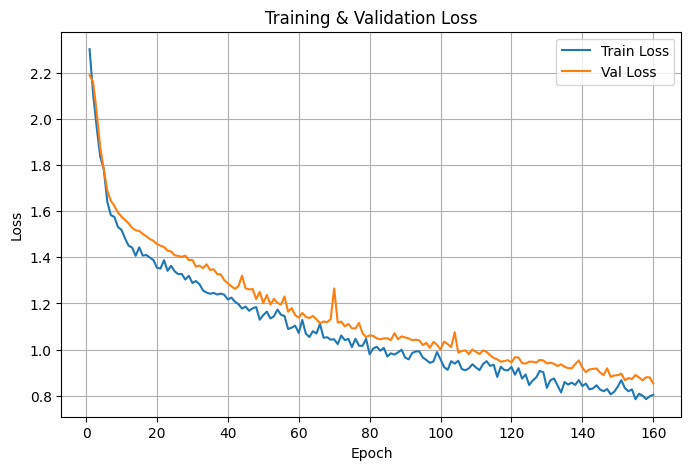

💾 Saved checkpoint: segformer_b5_adapter_epoch_160.pth
Epoch 161 | Train Loss: 0.8163 | Val Loss: 0.8633 | Val mIoU: 0.3105 | Val mCPA: 0.5612
Epoch 162 | Train Loss: 0.7889 | Val Loss: 0.8547 | Val mIoU: 0.3226 | Val mCPA: 0.5668
Epoch 163 | Train Loss: 0.7696 | Val Loss: 0.8823 | Val mIoU: 0.3217 | Val mCPA: 0.5555
Epoch 164 | Train Loss: 0.8029 | Val Loss: 0.8578 | Val mIoU: 0.3244 | Val mCPA: 0.5622
Epoch 165 | Train Loss: 0.7943 | Val Loss: 0.9052 | Val mIoU: 0.3116 | Val mCPA: 0.5591
Epoch 166 | Train Loss: 0.8200 | Val Loss: 0.8570 | Val mIoU: 0.3172 | Val mCPA: 0.5654
Epoch 167 | Train Loss: 0.8092 | Val Loss: 0.8696 | Val mIoU: 0.3195 | Val mCPA: 0.5644
Epoch 168 | Train Loss: 0.7913 | Val Loss: 0.8553 | Val mIoU: 0.3228 | Val mCPA: 0.5693
Epoch 169 | Train Loss: 0.7723 | Val Loss: 0.8693 | Val mIoU: 0.3172 | Val mCPA: 0.5637
Epoch 170 | Train Loss: 0.7591 | Val Loss: 0.8583 | Val mIoU: 0.3189 | Val mCPA: 0.5706


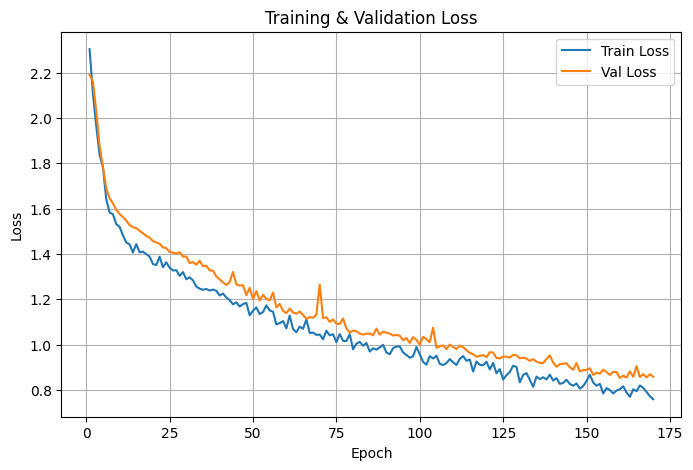

💾 Saved checkpoint: segformer_b5_adapter_epoch_170.pth
Epoch 171 | Train Loss: 0.7969 | Val Loss: 0.8617 | Val mIoU: 0.3198 | Val mCPA: 0.5711
Epoch 172 | Train Loss: 0.7998 | Val Loss: 0.8534 | Val mIoU: 0.3343 | Val mCPA: 0.5713
Epoch 173 | Train Loss: 0.7738 | Val Loss: 0.8516 | Val mIoU: 0.3339 | Val mCPA: 0.5760
Epoch 174 | Train Loss: 0.7631 | Val Loss: 0.8389 | Val mIoU: 0.3424 | Val mCPA: 0.5683
Epoch 175 | Train Loss: 0.7602 | Val Loss: 0.8614 | Val mIoU: 0.3318 | Val mCPA: 0.5653
Epoch 176 | Train Loss: 0.7591 | Val Loss: 0.8498 | Val mIoU: 0.3210 | Val mCPA: 0.5630
Epoch 177 | Train Loss: 0.7999 | Val Loss: 0.8567 | Val mIoU: 0.3193 | Val mCPA: 0.5571
Epoch 178 | Train Loss: 0.7432 | Val Loss: 0.8649 | Val mIoU: 0.3221 | Val mCPA: 0.5687
Epoch 179 | Train Loss: 0.7755 | Val Loss: 0.8481 | Val mIoU: 0.3339 | Val mCPA: 0.5688
Epoch 180 | Train Loss: 0.7539 | Val Loss: 0.8553 | Val mIoU: 0.3233 | Val mCPA: 0.5735


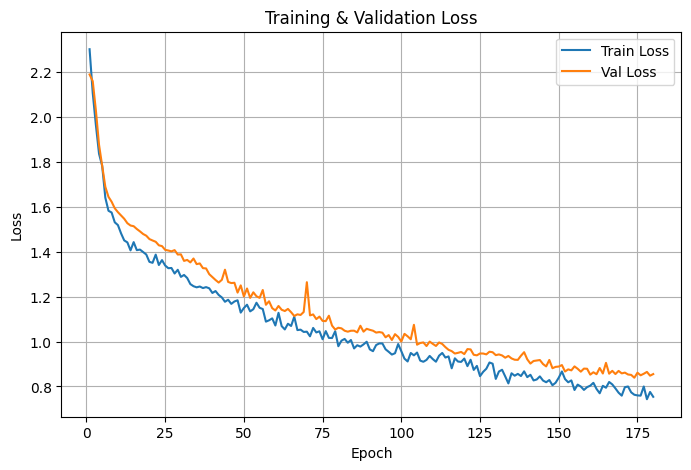

💾 Saved checkpoint: segformer_b5_adapter_epoch_180.pth
Epoch 181 | Train Loss: 0.7536 | Val Loss: 0.8298 | Val mIoU: 0.3409 | Val mCPA: 0.5780
Epoch 182 | Train Loss: 0.7824 | Val Loss: 0.8723 | Val mIoU: 0.3372 | Val mCPA: 0.5711
Epoch 183 | Train Loss: 0.7262 | Val Loss: 0.8623 | Val mIoU: 0.3224 | Val mCPA: 0.5691
Epoch 184 | Train Loss: 0.7484 | Val Loss: 0.8398 | Val mIoU: 0.3282 | Val mCPA: 0.5673
Epoch 185 | Train Loss: 0.7558 | Val Loss: 0.8204 | Val mIoU: 0.3358 | Val mCPA: 0.5785
Epoch 186 | Train Loss: 0.7576 | Val Loss: 0.8184 | Val mIoU: 0.3191 | Val mCPA: 0.5749
Epoch 187 | Train Loss: 0.7516 | Val Loss: 0.8131 | Val mIoU: 0.3395 | Val mCPA: 0.5842
Epoch 188 | Train Loss: 0.7510 | Val Loss: 0.8267 | Val mIoU: 0.3225 | Val mCPA: 0.5768
Epoch 189 | Train Loss: 0.7516 | Val Loss: 0.8174 | Val mIoU: 0.3365 | Val mCPA: 0.5727
Epoch 190 | Train Loss: 0.7848 | Val Loss: 0.8310 | Val mIoU: 0.3353 | Val mCPA: 0.5740


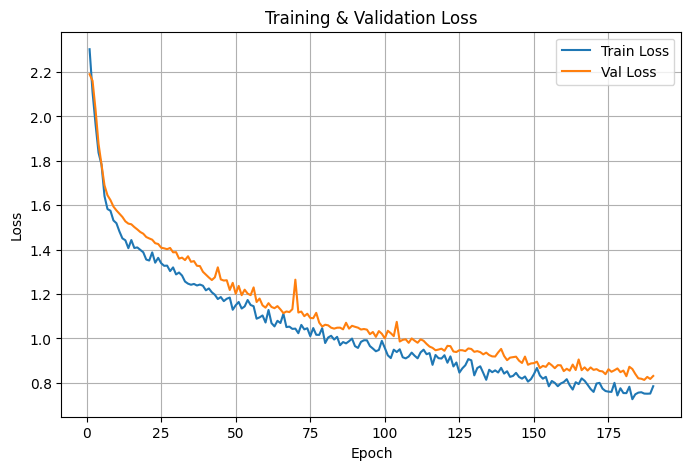

💾 Saved checkpoint: segformer_b5_adapter_epoch_190.pth
Epoch 191 | Train Loss: 0.7462 | Val Loss: 0.8164 | Val mIoU: 0.3433 | Val mCPA: 0.5750
Epoch 192 | Train Loss: 0.7677 | Val Loss: 0.8116 | Val mIoU: 0.3404 | Val mCPA: 0.5882
Epoch 193 | Train Loss: 0.7356 | Val Loss: 0.8015 | Val mIoU: 0.3512 | Val mCPA: 0.5824
Epoch 194 | Train Loss: 0.7515 | Val Loss: 0.7903 | Val mIoU: 0.3462 | Val mCPA: 0.5892
Epoch 195 | Train Loss: 0.7514 | Val Loss: 0.8087 | Val mIoU: 0.3407 | Val mCPA: 0.5896
Epoch 196 | Train Loss: 0.7446 | Val Loss: 0.7961 | Val mIoU: 0.3395 | Val mCPA: 0.5834
Epoch 197 | Train Loss: 0.7503 | Val Loss: 0.7964 | Val mIoU: 0.3416 | Val mCPA: 0.5898
Epoch 198 | Train Loss: 0.7734 | Val Loss: 0.8077 | Val mIoU: 0.3396 | Val mCPA: 0.5814
Epoch 199 | Train Loss: 0.7450 | Val Loss: 0.8133 | Val mIoU: 0.3494 | Val mCPA: 0.5792
Epoch 200 | Train Loss: 0.7718 | Val Loss: 0.8167 | Val mIoU: 0.3416 | Val mCPA: 0.5779


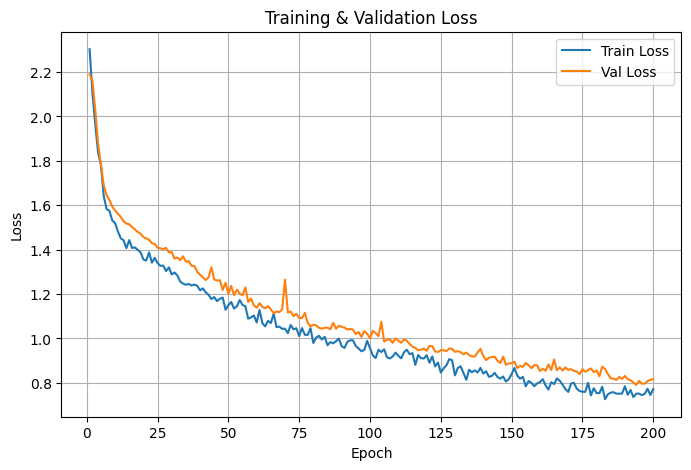

💾 Saved checkpoint: segformer_b5_adapter_epoch_200.pth
Epoch 201 | Train Loss: 0.7461 | Val Loss: 0.8109 | Val mIoU: 0.3472 | Val mCPA: 0.5824
Epoch 202 | Train Loss: 0.6966 | Val Loss: 0.8387 | Val mIoU: 0.3315 | Val mCPA: 0.5649
Epoch 203 | Train Loss: 0.7157 | Val Loss: 0.8156 | Val mIoU: 0.3424 | Val mCPA: 0.5757
Epoch 204 | Train Loss: 0.7369 | Val Loss: 0.8000 | Val mIoU: 0.3493 | Val mCPA: 0.5811
Epoch 205 | Train Loss: 0.7255 | Val Loss: 0.8138 | Val mIoU: 0.3448 | Val mCPA: 0.5821
Epoch 206 | Train Loss: 0.7216 | Val Loss: 0.8114 | Val mIoU: 0.3317 | Val mCPA: 0.5882
Epoch 207 | Train Loss: 0.7012 | Val Loss: 0.7896 | Val mIoU: 0.3547 | Val mCPA: 0.5822
Epoch 208 | Train Loss: 0.6994 | Val Loss: 0.8109 | Val mIoU: 0.3479 | Val mCPA: 0.5821
Epoch 209 | Train Loss: 0.7009 | Val Loss: 0.8099 | Val mIoU: 0.3377 | Val mCPA: 0.5864
Epoch 210 | Train Loss: 0.7326 | Val Loss: 0.7770 | Val mIoU: 0.3489 | Val mCPA: 0.5977


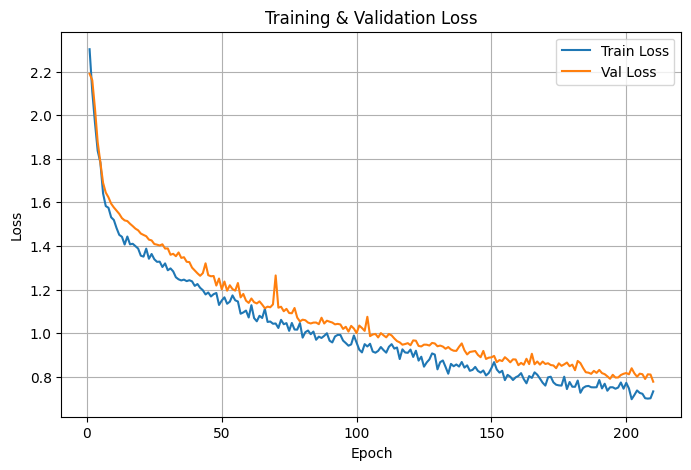

💾 Saved checkpoint: segformer_b5_adapter_epoch_210.pth
Epoch 211 | Train Loss: 0.6968 | Val Loss: 0.7971 | Val mIoU: 0.3597 | Val mCPA: 0.5891
Epoch 212 | Train Loss: 0.7351 | Val Loss: 0.7782 | Val mIoU: 0.3517 | Val mCPA: 0.5932
Epoch 213 | Train Loss: 0.7052 | Val Loss: 0.7907 | Val mIoU: 0.3569 | Val mCPA: 0.5928
Epoch 214 | Train Loss: 0.6762 | Val Loss: 0.8006 | Val mIoU: 0.3463 | Val mCPA: 0.5885
Epoch 215 | Train Loss: 0.7202 | Val Loss: 0.8138 | Val mIoU: 0.3489 | Val mCPA: 0.5819
Epoch 216 | Train Loss: 0.6884 | Val Loss: 0.7905 | Val mIoU: 0.3507 | Val mCPA: 0.5843
Epoch 217 | Train Loss: 0.6739 | Val Loss: 0.7710 | Val mIoU: 0.3685 | Val mCPA: 0.5904
Epoch 218 | Train Loss: 0.7079 | Val Loss: 0.8014 | Val mIoU: 0.3394 | Val mCPA: 0.5860
Epoch 219 | Train Loss: 0.6941 | Val Loss: 0.8046 | Val mIoU: 0.3465 | Val mCPA: 0.5829
Epoch 220 | Train Loss: 0.6955 | Val Loss: 0.7906 | Val mIoU: 0.3633 | Val mCPA: 0.5877


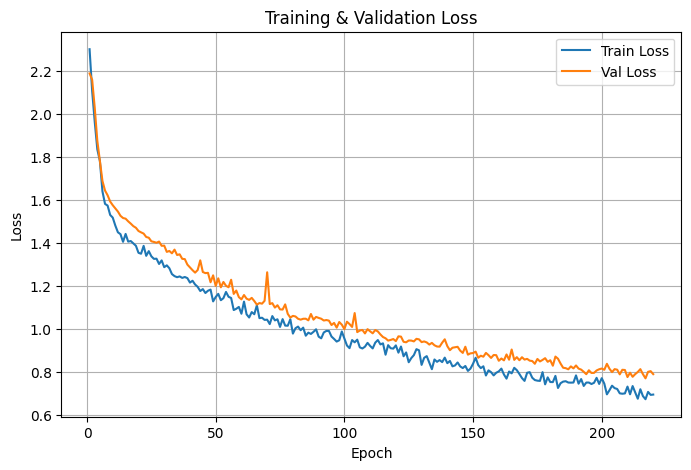

💾 Saved checkpoint: segformer_b5_adapter_epoch_220.pth
Epoch 221 | Train Loss: 0.7244 | Val Loss: 0.7925 | Val mIoU: 0.3566 | Val mCPA: 0.5873
Epoch 222 | Train Loss: 0.7016 | Val Loss: 0.7857 | Val mIoU: 0.3573 | Val mCPA: 0.5813
Epoch 223 | Train Loss: 0.6763 | Val Loss: 0.7914 | Val mIoU: 0.3434 | Val mCPA: 0.5924
Epoch 224 | Train Loss: 0.6870 | Val Loss: 0.7750 | Val mIoU: 0.3752 | Val mCPA: 0.5832
Epoch 225 | Train Loss: 0.7293 | Val Loss: 0.7970 | Val mIoU: 0.3491 | Val mCPA: 0.5790
Epoch 226 | Train Loss: 0.6984 | Val Loss: 0.7671 | Val mIoU: 0.3589 | Val mCPA: 0.5901
Epoch 227 | Train Loss: 0.6739 | Val Loss: 0.7778 | Val mIoU: 0.3690 | Val mCPA: 0.5934
Epoch 228 | Train Loss: 0.6900 | Val Loss: 0.8204 | Val mIoU: 0.3444 | Val mCPA: 0.5763
Epoch 229 | Train Loss: 0.6882 | Val Loss: 0.8104 | Val mIoU: 0.3366 | Val mCPA: 0.5880
Epoch 230 | Train Loss: 0.6842 | Val Loss: 0.8263 | Val mIoU: 0.3240 | Val mCPA: 0.5740


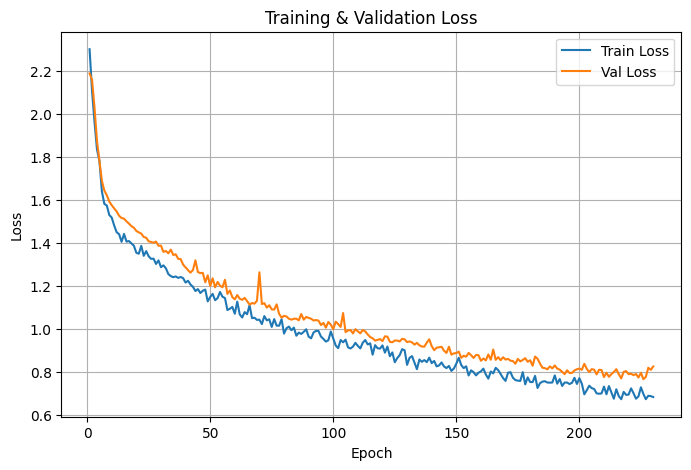

💾 Saved checkpoint: segformer_b5_adapter_epoch_230.pth
Epoch 231 | Train Loss: 0.6852 | Val Loss: 0.7924 | Val mIoU: 0.3611 | Val mCPA: 0.5889
Epoch 232 | Train Loss: 0.6882 | Val Loss: 0.7658 | Val mIoU: 0.3806 | Val mCPA: 0.5952
Epoch 233 | Train Loss: 0.6804 | Val Loss: 0.8117 | Val mIoU: 0.3501 | Val mCPA: 0.5820
Epoch 234 | Train Loss: 0.6850 | Val Loss: 0.7680 | Val mIoU: 0.3761 | Val mCPA: 0.5947
Epoch 235 | Train Loss: 0.6811 | Val Loss: 0.7452 | Val mIoU: 0.3905 | Val mCPA: 0.5937
Epoch 236 | Train Loss: 0.6777 | Val Loss: 0.7927 | Val mIoU: 0.3597 | Val mCPA: 0.5808
Epoch 237 | Train Loss: 0.6714 | Val Loss: 0.7705 | Val mIoU: 0.3742 | Val mCPA: 0.5831
Epoch 238 | Train Loss: 0.7078 | Val Loss: 0.7521 | Val mIoU: 0.3818 | Val mCPA: 0.5899
Epoch 239 | Train Loss: 0.6489 | Val Loss: 0.7667 | Val mIoU: 0.3822 | Val mCPA: 0.5808
Epoch 240 | Train Loss: 0.7100 | Val Loss: 0.7773 | Val mIoU: 0.3732 | Val mCPA: 0.5922


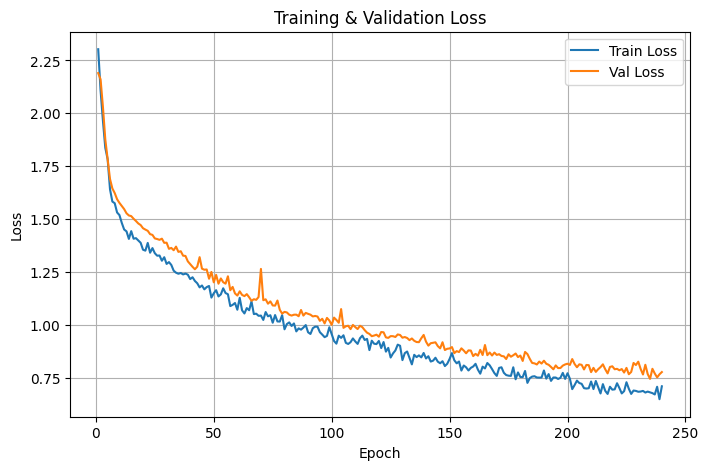

💾 Saved checkpoint: segformer_b5_adapter_epoch_240.pth
Epoch 241 | Train Loss: 0.6677 | Val Loss: 0.7485 | Val mIoU: 0.3844 | Val mCPA: 0.6055
Epoch 242 | Train Loss: 0.7081 | Val Loss: 0.8148 | Val mIoU: 0.3511 | Val mCPA: 0.5758
Epoch 243 | Train Loss: 0.6850 | Val Loss: 0.7866 | Val mIoU: 0.3600 | Val mCPA: 0.5834
Epoch 244 | Train Loss: 0.6767 | Val Loss: 0.7415 | Val mIoU: 0.3816 | Val mCPA: 0.5916
Epoch 245 | Train Loss: 0.6769 | Val Loss: 0.7594 | Val mIoU: 0.3762 | Val mCPA: 0.5909
Epoch 246 | Train Loss: 0.6843 | Val Loss: 0.7572 | Val mIoU: 0.3754 | Val mCPA: 0.5899
Epoch 247 | Train Loss: 0.6514 | Val Loss: 0.7469 | Val mIoU: 0.3939 | Val mCPA: 0.5959
Epoch 248 | Train Loss: 0.6633 | Val Loss: 0.7906 | Val mIoU: 0.3543 | Val mCPA: 0.5797
Epoch 249 | Train Loss: 0.6525 | Val Loss: 0.7699 | Val mIoU: 0.3816 | Val mCPA: 0.5844
Epoch 250 | Train Loss: 0.6169 | Val Loss: 0.8044 | Val mIoU: 0.3555 | Val mCPA: 0.5816


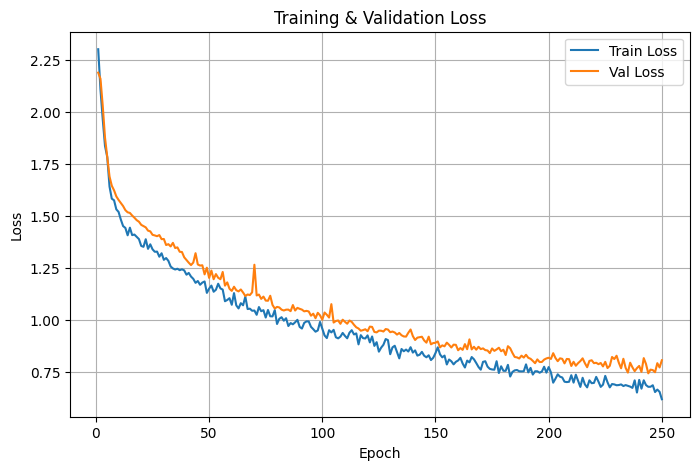

💾 Saved checkpoint: segformer_b5_adapter_epoch_250.pth
Epoch 251 | Train Loss: 0.6602 | Val Loss: 0.7637 | Val mIoU: 0.3796 | Val mCPA: 0.5850
Epoch 252 | Train Loss: 0.6561 | Val Loss: 0.7683 | Val mIoU: 0.3655 | Val mCPA: 0.5865
Epoch 253 | Train Loss: 0.6745 | Val Loss: 0.7554 | Val mIoU: 0.3595 | Val mCPA: 0.5924
Epoch 254 | Train Loss: 0.6480 | Val Loss: 0.7657 | Val mIoU: 0.3595 | Val mCPA: 0.5990
Epoch 255 | Train Loss: 0.6725 | Val Loss: 0.7145 | Val mIoU: 0.3867 | Val mCPA: 0.6102
Epoch 256 | Train Loss: 0.6377 | Val Loss: 0.7476 | Val mIoU: 0.3659 | Val mCPA: 0.5947
Epoch 257 | Train Loss: 0.6853 | Val Loss: 0.7588 | Val mIoU: 0.3631 | Val mCPA: 0.5832
Epoch 258 | Train Loss: 0.6333 | Val Loss: 0.7523 | Val mIoU: 0.3705 | Val mCPA: 0.5924
Epoch 259 | Train Loss: 0.6292 | Val Loss: 0.7821 | Val mIoU: 0.3550 | Val mCPA: 0.5894
Epoch 260 | Train Loss: 0.6405 | Val Loss: 0.7548 | Val mIoU: 0.3672 | Val mCPA: 0.5885


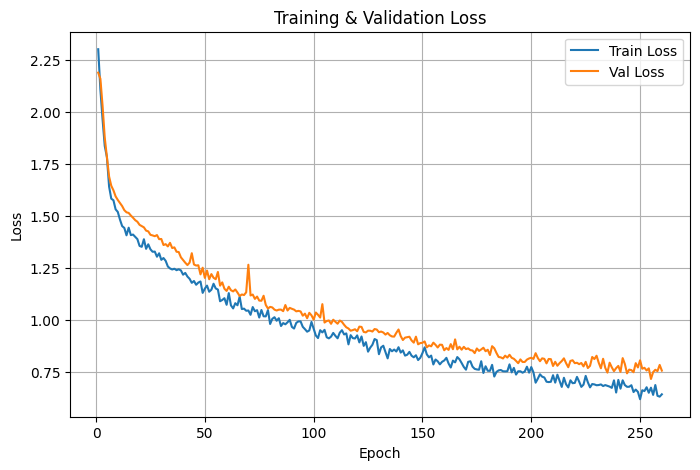

💾 Saved checkpoint: segformer_b5_adapter_epoch_260.pth
Epoch 261 | Train Loss: 0.6331 | Val Loss: 0.7496 | Val mIoU: 0.3749 | Val mCPA: 0.6014
Epoch 262 | Train Loss: 0.6664 | Val Loss: 0.7457 | Val mIoU: 0.3927 | Val mCPA: 0.6020
Epoch 263 | Train Loss: 0.6509 | Val Loss: 0.7422 | Val mIoU: 0.3784 | Val mCPA: 0.5986
Epoch 264 | Train Loss: 0.6229 | Val Loss: 0.7322 | Val mIoU: 0.3882 | Val mCPA: 0.6032
Epoch 265 | Train Loss: 0.6126 | Val Loss: 0.7725 | Val mIoU: 0.3704 | Val mCPA: 0.5873
Epoch 266 | Train Loss: 0.6257 | Val Loss: 0.7525 | Val mIoU: 0.3786 | Val mCPA: 0.5955
Epoch 267 | Train Loss: 0.6703 | Val Loss: 0.7773 | Val mIoU: 0.3530 | Val mCPA: 0.5867
Epoch 268 | Train Loss: 0.6169 | Val Loss: 0.7461 | Val mIoU: 0.3906 | Val mCPA: 0.6017
Epoch 269 | Train Loss: 0.6194 | Val Loss: 0.7322 | Val mIoU: 0.3803 | Val mCPA: 0.5931
Epoch 270 | Train Loss: 0.6201 | Val Loss: 0.7471 | Val mIoU: 0.3712 | Val mCPA: 0.5977


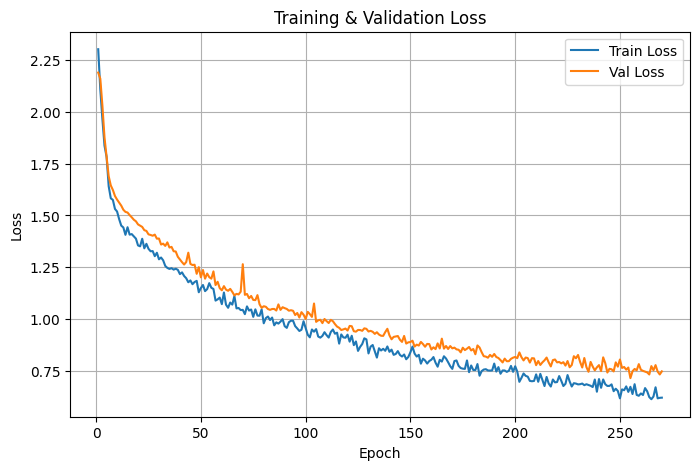

💾 Saved checkpoint: segformer_b5_adapter_epoch_270.pth
Epoch 271 | Train Loss: 0.6248 | Val Loss: 0.7439 | Val mIoU: 0.3755 | Val mCPA: 0.5956
Epoch 272 | Train Loss: 0.6127 | Val Loss: 0.7404 | Val mIoU: 0.3739 | Val mCPA: 0.5930
Epoch 273 | Train Loss: 0.6288 | Val Loss: 0.7663 | Val mIoU: 0.3569 | Val mCPA: 0.5877
Epoch 274 | Train Loss: 0.6430 | Val Loss: 0.7672 | Val mIoU: 0.3630 | Val mCPA: 0.5892
Epoch 275 | Train Loss: 0.6225 | Val Loss: 0.7406 | Val mIoU: 0.3758 | Val mCPA: 0.5934
Epoch 276 | Train Loss: 0.6369 | Val Loss: 0.7214 | Val mIoU: 0.4073 | Val mCPA: 0.6049
Epoch 277 | Train Loss: 0.6326 | Val Loss: 0.7486 | Val mIoU: 0.3785 | Val mCPA: 0.6024
Epoch 278 | Train Loss: 0.6369 | Val Loss: 0.7633 | Val mIoU: 0.3571 | Val mCPA: 0.5934
Epoch 279 | Train Loss: 0.6369 | Val Loss: 0.7603 | Val mIoU: 0.3787 | Val mCPA: 0.5873
Epoch 280 | Train Loss: 0.6348 | Val Loss: 0.7520 | Val mIoU: 0.3599 | Val mCPA: 0.5905


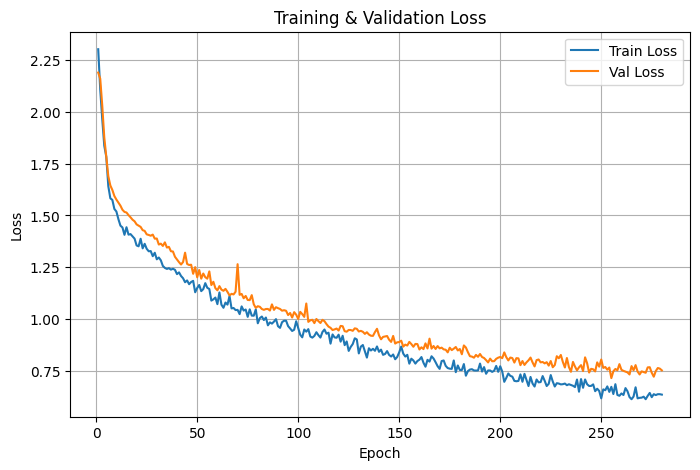

💾 Saved checkpoint: segformer_b5_adapter_epoch_280.pth
Epoch 281 | Train Loss: 0.6124 | Val Loss: 0.7440 | Val mIoU: 0.3859 | Val mCPA: 0.5988
Epoch 282 | Train Loss: 0.6267 | Val Loss: 0.7545 | Val mIoU: 0.3772 | Val mCPA: 0.5992
Epoch 283 | Train Loss: 0.5944 | Val Loss: 0.7230 | Val mIoU: 0.3935 | Val mCPA: 0.5961
Epoch 284 | Train Loss: 0.6271 | Val Loss: 0.7470 | Val mIoU: 0.3775 | Val mCPA: 0.5967
Epoch 285 | Train Loss: 0.6032 | Val Loss: 0.7597 | Val mIoU: 0.3678 | Val mCPA: 0.5827
Epoch 286 | Train Loss: 0.6304 | Val Loss: 0.7665 | Val mIoU: 0.3834 | Val mCPA: 0.5918
Epoch 287 | Train Loss: 0.6095 | Val Loss: 0.7855 | Val mIoU: 0.3492 | Val mCPA: 0.5848
Epoch 288 | Train Loss: 0.6139 | Val Loss: 0.7144 | Val mIoU: 0.3790 | Val mCPA: 0.6033
Epoch 289 | Train Loss: 0.6476 | Val Loss: 0.7513 | Val mIoU: 0.3680 | Val mCPA: 0.5973
Epoch 290 | Train Loss: 0.6123 | Val Loss: 0.7576 | Val mIoU: 0.3691 | Val mCPA: 0.5937


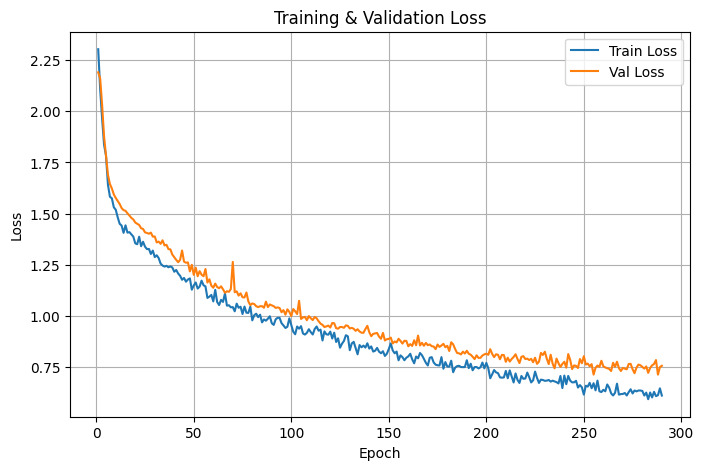

💾 Saved checkpoint: segformer_b5_adapter_epoch_290.pth
Epoch 291 | Train Loss: 0.6035 | Val Loss: 0.7641 | Val mIoU: 0.3746 | Val mCPA: 0.5888
Epoch 292 | Train Loss: 0.5832 | Val Loss: 0.7605 | Val mIoU: 0.3728 | Val mCPA: 0.5931
Epoch 293 | Train Loss: 0.5998 | Val Loss: 0.7487 | Val mIoU: 0.3801 | Val mCPA: 0.5943
Epoch 294 | Train Loss: 0.5820 | Val Loss: 0.7569 | Val mIoU: 0.3534 | Val mCPA: 0.5918
Epoch 295 | Train Loss: 0.6114 | Val Loss: 0.7569 | Val mIoU: 0.3754 | Val mCPA: 0.5986
Epoch 296 | Train Loss: 0.6083 | Val Loss: 0.7371 | Val mIoU: 0.3739 | Val mCPA: 0.5904
Epoch 297 | Train Loss: 0.6219 | Val Loss: 0.7395 | Val mIoU: 0.3843 | Val mCPA: 0.5973
Epoch 298 | Train Loss: 0.5768 | Val Loss: 0.7319 | Val mIoU: 0.3802 | Val mCPA: 0.5998
Epoch 299 | Train Loss: 0.6171 | Val Loss: 0.7711 | Val mIoU: 0.3770 | Val mCPA: 0.5863
Epoch 300 | Train Loss: 0.5832 | Val Loss: 0.7377 | Val mIoU: 0.3635 | Val mCPA: 0.5962


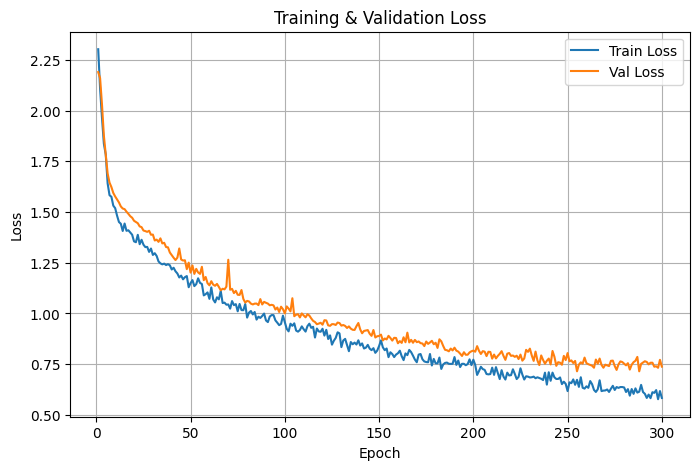

💾 Saved checkpoint: segformer_b5_adapter_epoch_300.pth
Epoch 301 | Train Loss: 0.5866 | Val Loss: 0.7848 | Val mIoU: 0.3592 | Val mCPA: 0.5954
Epoch 302 | Train Loss: 0.5715 | Val Loss: 0.7353 | Val mIoU: 0.3817 | Val mCPA: 0.6017
Epoch 303 | Train Loss: 0.5961 | Val Loss: 0.7548 | Val mIoU: 0.3678 | Val mCPA: 0.6005
Epoch 304 | Train Loss: 0.5495 | Val Loss: 0.7617 | Val mIoU: 0.3729 | Val mCPA: 0.5940
Epoch 305 | Train Loss: 0.5873 | Val Loss: 0.8247 | Val mIoU: 0.3482 | Val mCPA: 0.5867
Epoch 306 | Train Loss: 0.5916 | Val Loss: 0.7477 | Val mIoU: 0.3726 | Val mCPA: 0.5915
Epoch 307 | Train Loss: 0.5908 | Val Loss: 0.7037 | Val mIoU: 0.3805 | Val mCPA: 0.6056
Epoch 308 | Train Loss: 0.6149 | Val Loss: 0.7548 | Val mIoU: 0.3619 | Val mCPA: 0.5837
Epoch 309 | Train Loss: 0.5623 | Val Loss: 0.7207 | Val mIoU: 0.3804 | Val mCPA: 0.5988
Epoch 310 | Train Loss: 0.6034 | Val Loss: 0.6961 | Val mIoU: 0.3958 | Val mCPA: 0.6115


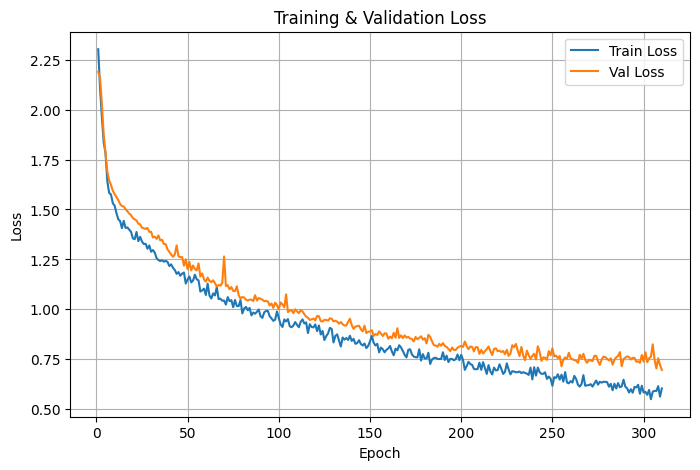

💾 Saved checkpoint: segformer_b5_adapter_epoch_310.pth
Epoch 311 | Train Loss: 0.6058 | Val Loss: 0.7589 | Val mIoU: 0.3851 | Val mCPA: 0.5903
Epoch 312 | Train Loss: 0.6277 | Val Loss: 0.7461 | Val mIoU: 0.3787 | Val mCPA: 0.5926
Epoch 313 | Train Loss: 0.5786 | Val Loss: 0.7731 | Val mIoU: 0.3661 | Val mCPA: 0.5848
Epoch 314 | Train Loss: 0.5884 | Val Loss: 0.7222 | Val mIoU: 0.3823 | Val mCPA: 0.6013
Epoch 315 | Train Loss: 0.5952 | Val Loss: 0.7211 | Val mIoU: 0.3796 | Val mCPA: 0.6105
Epoch 316 | Train Loss: 0.5839 | Val Loss: 0.7595 | Val mIoU: 0.3674 | Val mCPA: 0.5954
Epoch 317 | Train Loss: 0.5970 | Val Loss: 0.7292 | Val mIoU: 0.3888 | Val mCPA: 0.5976
Epoch 318 | Train Loss: 0.6050 | Val Loss: 0.7449 | Val mIoU: 0.3889 | Val mCPA: 0.5976
Epoch 319 | Train Loss: 0.5977 | Val Loss: 0.7148 | Val mIoU: 0.3976 | Val mCPA: 0.5979
Epoch 320 | Train Loss: 0.5801 | Val Loss: 0.7305 | Val mIoU: 0.3898 | Val mCPA: 0.5984


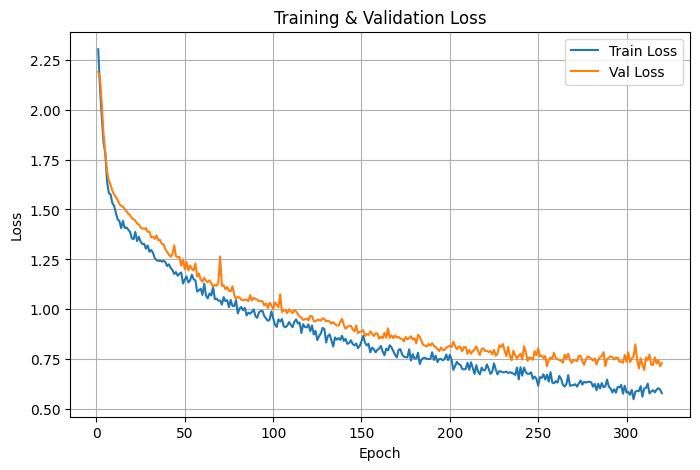

💾 Saved checkpoint: segformer_b5_adapter_epoch_320.pth
Epoch 321 | Train Loss: 0.5824 | Val Loss: 0.7347 | Val mIoU: 0.3754 | Val mCPA: 0.6055
Epoch 322 | Train Loss: 0.5765 | Val Loss: 0.7435 | Val mIoU: 0.3816 | Val mCPA: 0.5999
Epoch 323 | Train Loss: 0.5852 | Val Loss: 0.7313 | Val mIoU: 0.3762 | Val mCPA: 0.5971
Epoch 324 | Train Loss: 0.5572 | Val Loss: 0.7186 | Val mIoU: 0.3854 | Val mCPA: 0.6063
Epoch 325 | Train Loss: 0.5807 | Val Loss: 0.7499 | Val mIoU: 0.3738 | Val mCPA: 0.6030
Epoch 326 | Train Loss: 0.5977 | Val Loss: 0.7225 | Val mIoU: 0.3837 | Val mCPA: 0.6057
Epoch 327 | Train Loss: 0.5787 | Val Loss: 0.7372 | Val mIoU: 0.3774 | Val mCPA: 0.6006
Epoch 328 | Train Loss: 0.5867 | Val Loss: 0.7275 | Val mIoU: 0.3935 | Val mCPA: 0.6001
Epoch 329 | Train Loss: 0.5797 | Val Loss: 0.7295 | Val mIoU: 0.3907 | Val mCPA: 0.6060
Epoch 330 | Train Loss: 0.5842 | Val Loss: 0.7256 | Val mIoU: 0.3682 | Val mCPA: 0.6092


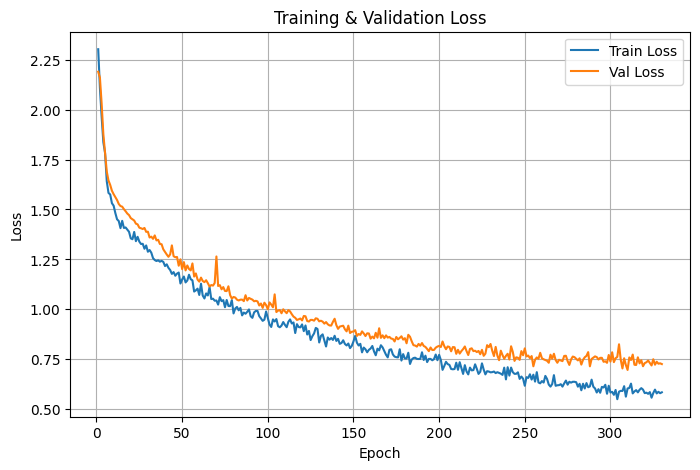

💾 Saved checkpoint: segformer_b5_adapter_epoch_330.pth
Epoch 331 | Train Loss: 0.5648 | Val Loss: 0.7555 | Val mIoU: 0.3774 | Val mCPA: 0.5956
Epoch 332 | Train Loss: 0.5727 | Val Loss: 0.7159 | Val mIoU: 0.3925 | Val mCPA: 0.6078
Epoch 333 | Train Loss: 0.5476 | Val Loss: 0.7803 | Val mIoU: 0.3720 | Val mCPA: 0.5968
Epoch 334 | Train Loss: 0.5560 | Val Loss: 0.7547 | Val mIoU: 0.3832 | Val mCPA: 0.5973
Epoch 335 | Train Loss: 0.5470 | Val Loss: 0.7666 | Val mIoU: 0.3695 | Val mCPA: 0.5963
Epoch 336 | Train Loss: 0.5557 | Val Loss: 0.7747 | Val mIoU: 0.3739 | Val mCPA: 0.5896
Epoch 337 | Train Loss: 0.5605 | Val Loss: 0.7292 | Val mIoU: 0.3755 | Val mCPA: 0.5963
Epoch 338 | Train Loss: 0.5639 | Val Loss: 0.7404 | Val mIoU: 0.3702 | Val mCPA: 0.5944
Epoch 339 | Train Loss: 0.5716 | Val Loss: 0.7459 | Val mIoU: 0.3718 | Val mCPA: 0.6015
Epoch 340 | Train Loss: 0.5633 | Val Loss: 0.7412 | Val mIoU: 0.3797 | Val mCPA: 0.6027


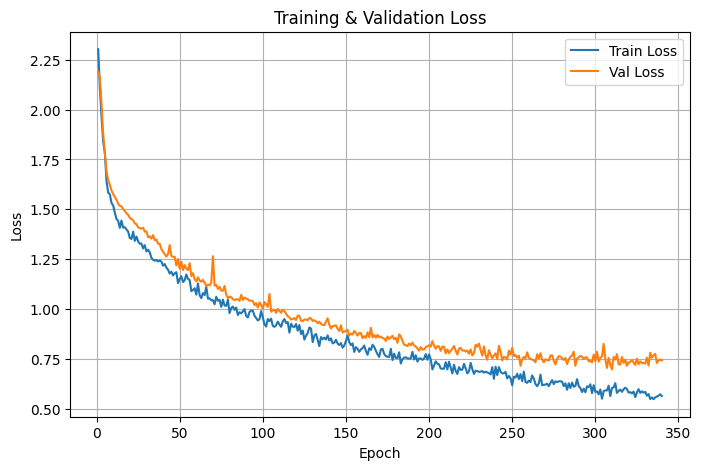

💾 Saved checkpoint: segformer_b5_adapter_epoch_340.pth
Epoch 341 | Train Loss: 0.5501 | Val Loss: 0.7550 | Val mIoU: 0.3813 | Val mCPA: 0.5978
Epoch 342 | Train Loss: 0.5778 | Val Loss: 0.7253 | Val mIoU: 0.3966 | Val mCPA: 0.6060
Epoch 343 | Train Loss: 0.5588 | Val Loss: 0.7202 | Val mIoU: 0.3845 | Val mCPA: 0.6117
Epoch 344 | Train Loss: 0.5757 | Val Loss: 0.8263 | Val mIoU: 0.3696 | Val mCPA: 0.5906
Epoch 345 | Train Loss: 0.5848 | Val Loss: 0.7088 | Val mIoU: 0.3948 | Val mCPA: 0.6156
Epoch 346 | Train Loss: 0.5538 | Val Loss: 0.6997 | Val mIoU: 0.3976 | Val mCPA: 0.6120
Epoch 347 | Train Loss: 0.5845 | Val Loss: 0.7304 | Val mIoU: 0.3914 | Val mCPA: 0.5956
Epoch 348 | Train Loss: 0.5634 | Val Loss: 0.7202 | Val mIoU: 0.3956 | Val mCPA: 0.6102
Epoch 349 | Train Loss: 0.5691 | Val Loss: 0.7471 | Val mIoU: 0.3860 | Val mCPA: 0.6115
Epoch 350 | Train Loss: 0.5712 | Val Loss: 0.7582 | Val mIoU: 0.3874 | Val mCPA: 0.5998


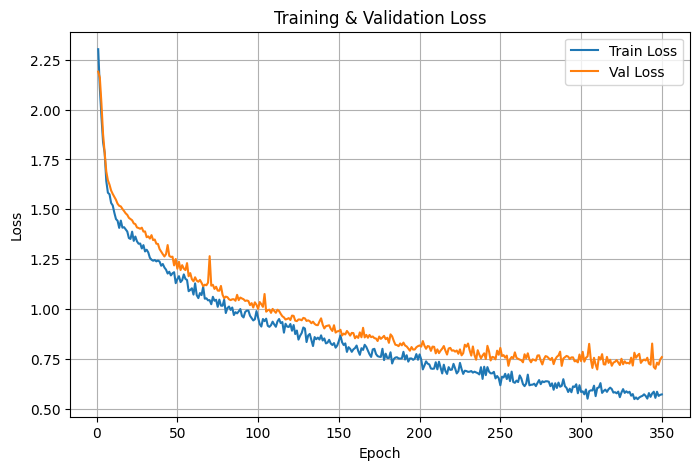

💾 Saved checkpoint: segformer_b5_adapter_epoch_350.pth
Epoch 351 | Train Loss: 0.5493 | Val Loss: 0.7400 | Val mIoU: 0.3857 | Val mCPA: 0.5986
Epoch 352 | Train Loss: 0.5441 | Val Loss: 0.7498 | Val mIoU: 0.3764 | Val mCPA: 0.6014
Epoch 353 | Train Loss: 0.5197 | Val Loss: 0.7829 | Val mIoU: 0.3673 | Val mCPA: 0.5922
Epoch 354 | Train Loss: 0.5542 | Val Loss: 0.7507 | Val mIoU: 0.3737 | Val mCPA: 0.5980
Epoch 355 | Train Loss: 0.5635 | Val Loss: 0.7510 | Val mIoU: 0.3972 | Val mCPA: 0.6019
Epoch 356 | Train Loss: 0.5430 | Val Loss: 0.7735 | Val mIoU: 0.3876 | Val mCPA: 0.6009
Epoch 357 | Train Loss: 0.5625 | Val Loss: 0.7057 | Val mIoU: 0.3932 | Val mCPA: 0.6092
Epoch 358 | Train Loss: 0.5306 | Val Loss: 0.7519 | Val mIoU: 0.3796 | Val mCPA: 0.5938
Epoch 359 | Train Loss: 0.5537 | Val Loss: 0.7583 | Val mIoU: 0.3891 | Val mCPA: 0.5945
Epoch 360 | Train Loss: 0.5398 | Val Loss: 0.7276 | Val mIoU: 0.3783 | Val mCPA: 0.5984


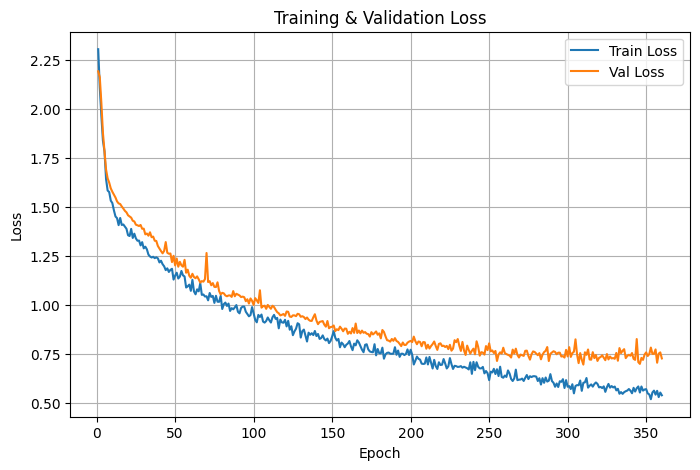

💾 Saved checkpoint: segformer_b5_adapter_epoch_360.pth
Epoch 361 | Train Loss: 0.5430 | Val Loss: 0.7758 | Val mIoU: 0.3782 | Val mCPA: 0.5966
Epoch 362 | Train Loss: 0.5574 | Val Loss: 0.7570 | Val mIoU: 0.3910 | Val mCPA: 0.5995
Epoch 363 | Train Loss: 0.5304 | Val Loss: 0.7450 | Val mIoU: 0.3811 | Val mCPA: 0.5971
Epoch 364 | Train Loss: 0.5378 | Val Loss: 0.7755 | Val mIoU: 0.3761 | Val mCPA: 0.5922
Epoch 365 | Train Loss: 0.5485 | Val Loss: 0.7505 | Val mIoU: 0.3899 | Val mCPA: 0.6027
Epoch 366 | Train Loss: 0.5554 | Val Loss: 0.7530 | Val mIoU: 0.3755 | Val mCPA: 0.5991
Epoch 367 | Train Loss: 0.5542 | Val Loss: 0.7299 | Val mIoU: 0.4064 | Val mCPA: 0.6045
Epoch 368 | Train Loss: 0.5415 | Val Loss: 0.7838 | Val mIoU: 0.3694 | Val mCPA: 0.5954
Epoch 369 | Train Loss: 0.5292 | Val Loss: 0.7493 | Val mIoU: 0.3806 | Val mCPA: 0.6022
Epoch 370 | Train Loss: 0.5314 | Val Loss: 0.7700 | Val mIoU: 0.3785 | Val mCPA: 0.6014


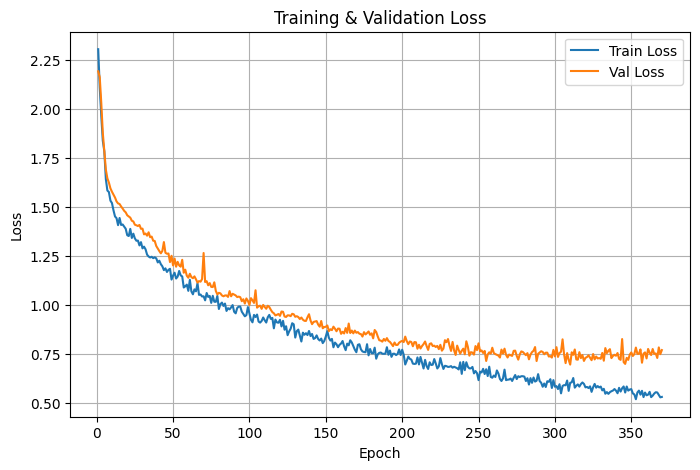

💾 Saved checkpoint: segformer_b5_adapter_epoch_370.pth
Epoch 371 | Train Loss: 0.5621 | Val Loss: 0.7154 | Val mIoU: 0.3960 | Val mCPA: 0.6103
Epoch 372 | Train Loss: 0.5197 | Val Loss: 0.7770 | Val mIoU: 0.3715 | Val mCPA: 0.5981
Epoch 373 | Train Loss: 0.5539 | Val Loss: 0.7213 | Val mIoU: 0.3808 | Val mCPA: 0.6044
Epoch 374 | Train Loss: 0.5254 | Val Loss: 0.7142 | Val mIoU: 0.3869 | Val mCPA: 0.6021
Epoch 375 | Train Loss: 0.5242 | Val Loss: 0.7269 | Val mIoU: 0.3749 | Val mCPA: 0.6087
Epoch 376 | Train Loss: 0.5144 | Val Loss: 0.7776 | Val mIoU: 0.3751 | Val mCPA: 0.5965
Epoch 377 | Train Loss: 0.5354 | Val Loss: 0.7713 | Val mIoU: 0.3835 | Val mCPA: 0.5999
Epoch 378 | Train Loss: 0.5349 | Val Loss: 0.7354 | Val mIoU: 0.3860 | Val mCPA: 0.6081
Epoch 379 | Train Loss: 0.5345 | Val Loss: 0.7616 | Val mIoU: 0.3890 | Val mCPA: 0.6050
Epoch 380 | Train Loss: 0.5725 | Val Loss: 0.7543 | Val mIoU: 0.3881 | Val mCPA: 0.6062


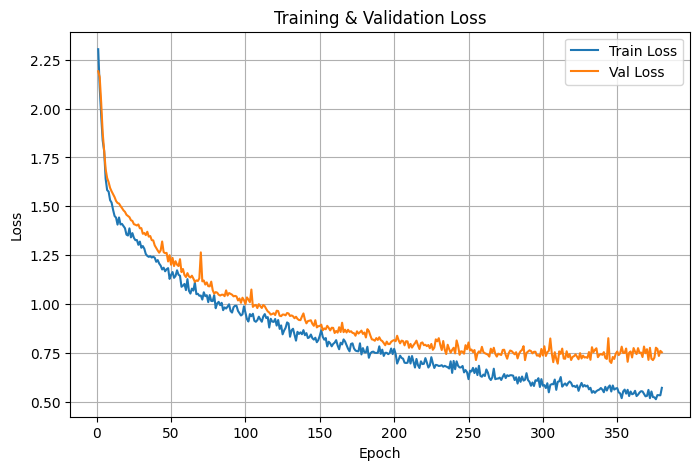

💾 Saved checkpoint: segformer_b5_adapter_epoch_380.pth


KeyboardInterrupt: 

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 9
NUM_EPOCHS = 500
LR = 1e-5   # higher for LoRA fine-tuning
WEIGHT_DECAY = 0.01


trainable = sum(p.numel() for p in model.base_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.base_model.parameters())
print(f"Trainable params: {trainable/total*100:.2f}% of total")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=WEIGHT_DECAY
)

train_losses, val_losses = [], []

def compute_metrics(pred, true, num_classes):
    correct = (pred == true).sum()
    total = np.prod(true.shape)
    CPA = []
    IoU = []
    for c in range(num_classes):
        tp = ((pred==c)&(true==c)).sum()
        fp = ((pred==c)&(true!=c)).sum()
        fn = ((pred!=c)&(true==c)).sum()
        cpa = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else np.nan
        IoU.append(iou)
        CPA.append(cpa)
    return np.nanmean(IoU), CPA

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.long().to(DEVICE)

        optimizer.zero_grad()
        outputs = model.base_model(imgs)

        # Handle dict outputs
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs

        # Upsample logits to match mask size
        logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)

        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ============================
    # Validation
    # ============================
    model.eval()
    epoch_val_loss = 0
    val_miou_list, val_cpa_list = [], []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.long().to(DEVICE)
            outputs = model.base_model(imgs)
            logits = outputs["logits"] if isinstance(outputs, dict) else outputs
            logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)

            loss = criterion(logits, masks)
            epoch_val_loss += loss.item()

            preds = logits.argmax(dim=1).cpu().numpy()
            masks_np = masks.cpu().numpy()
            for p, t in zip(preds, masks_np):
                miou, cpa = compute_metrics(p, t, NUM_CLASSES)
                val_miou_list.append(miou)
                val_cpa_list.append(cpa)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    mean_val_miou = np.nanmean(val_miou_list)
    mean_val_cpa = np.nanmean(val_cpa_list)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val mIoU: {mean_val_miou:.4f} | "
          f"Val mCPA: {mean_val_cpa:.4f}")

    # ============================
    # Periodic Save & Plot
    # ============================
    if (epoch + 1) % 10 == 0:
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training & Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses
        }, f"segformer_b5_adapter_epoch_{epoch+1}.pth")

        print(f"💾 Saved checkpoint: segformer_b5_adapter_epoch_{epoch+1}.pth")

print("✅ Training complete!")